In [1]:
#%%
import sys
sys.path.append('/home/gaoyuanw/Github/JaxSSO')
import JaxSSO.model as Model 
from JaxSSO import assemblemodel,solver
from JaxSSO.SSO_model import NodeParameter,ElementParameter,SSO_model
import numpy as np
import jax
import jax.numpy as jnp
from jax import jacfwd,grad,value_and_grad
from scipy.sparse.linalg import spsolve as spsolve_scipy
from scipy.sparse import csr_matrix
from jax.experimental import sparse
import os
#os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["TF_CPP_MIN_LOG_LEVEL"]="0"
jax.config.update("jax_enable_x64", True)
from jax.experimental import sparse
print(jax.__version__)
from platform import python_version
jax.config.update('jax_platform_name', 'cpu')
print(python_version())
import scipy
print(scipy.__version__)

import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.patches import Polygon

0.4.24
3.12.1
1.12.0


/tmp/ipykernel_957813/734137169.py:27: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
n_col =40
n_row = n_col
x_span = 6
y_span = 6


# Nodal coordinates
xs = np.linspace(0,x_span,n_col+1)
xs = np.tile(xs,n_row+1)
ys = np.linspace(0,y_span,n_row+1)
ys = np.tile(ys,(n_col+1,1))
ys = ys.T.reshape(-1)
#zs =  0.2*(-(np.linspace(0,x_span,n_col+1)-x_span/2)**2+(x_span/2)**2)

zs =  0.1*(-(xs-x_span/2)**2+(x_span/2)**2
          -(ys-x_span/2)**2+(x_span/2)**2)

'''zs = np.tile(zs,n_row+1)
zs = np.where(xs==0,0,zs)
zs = np.where(xs==x_span,0,zs)'''
'''zs = np.where(xs==0,0,zs)
zs = np.where(xs==x_span,0,zs)
zs = np.where(ys==0,0,zs)
zs = np.where(ys==y_span,0,zs)
'''

# Connectivity
n_node = (n_col+1)*(n_row+1)
n_ele = n_col * n_row
cnct = np.zeros((n_ele,4),dtype=int) #Connectivity for MITC4
for i in range(n_ele):
    i_row = i//n_col
    i_col = (i-i_row*n_col)%n_col
    cnct[i,3] = i + i_row*1 + n_col + 1
    cnct[i,2] = cnct[i,3]+1 
    cnct[i,1] = cnct[i,2] - (n_col + 1)
    cnct[i,0] = cnct[i,1] - 1

#Properties, design nodes, load
t = 0.015
E = 2e10
nu = 0.3
design_nodes = []
non_design_nodes = []
loading_nodes = []
for i in range(n_node):
    design_nodes.append(i)
    if [xs[i],ys[i]]!= [x_span/2,0] and [xs[i],ys[i]] != [0,y_span/2] and [xs[i],ys[i]] != [x_span/2,y_span] and [xs[i],ys[i]] != [x_span,y_span/2]:
        #design_nodes.append(i)
        if [xs[i],ys[i]]== [0,0] or [xs[i],ys[i]]== [x_span/2,y_span/2] or [xs[i],ys[i]]== [x_span,0] or [xs[i],ys[i]]== [0,y_span] or [xs[i],ys[i]]== [x_span,y_span]:
            loading_nodes.append(i)
        
    else:
        non_design_nodes.append(i)
design_nodes = np.asarray(design_nodes)
non_design_nodes = np.asarray(non_design_nodes)
Q = 500

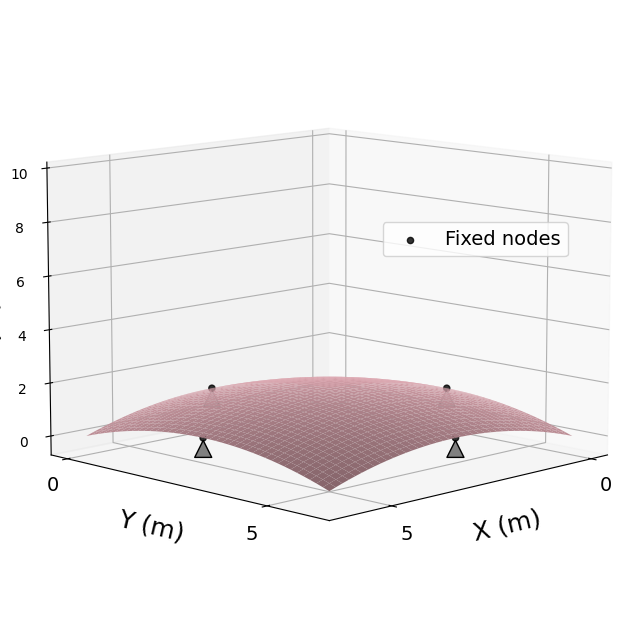

In [3]:
col = n_col+1
row = n_row+1 
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
X = xs.reshape((row,col))
Y = ys.reshape((row,col))
Z = zs.reshape((row,col))
ax.set_xlabel('X (m)',fontsize=18)
ax.set_ylabel('Y (m)',fontsize=18)
ax.set_zlabel('Z (m)',fontsize=18)
plt.yticks([0,5,10,15,20],fontsize=14)
plt.xticks([0,5,10,15,20],fontsize=14)

ax.set_zlim(-0.5, 20)
ax.set_zlim(-0.5, 20)
ax.set_zlim(-0.5, 10)
ax.plot_surface(X, Y, Z, color='pink')#cmap=plt.cm.YlGnBu_r) 
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes],color='black',alpha=0.8,label='Fixed nodes',s=20)
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes]-0.4, s=150, facecolors='grey', edgecolors='black',marker='^')
ax.view_init(10, 45)
plt.legend(loc=(0.6,0.6),fontsize=14)

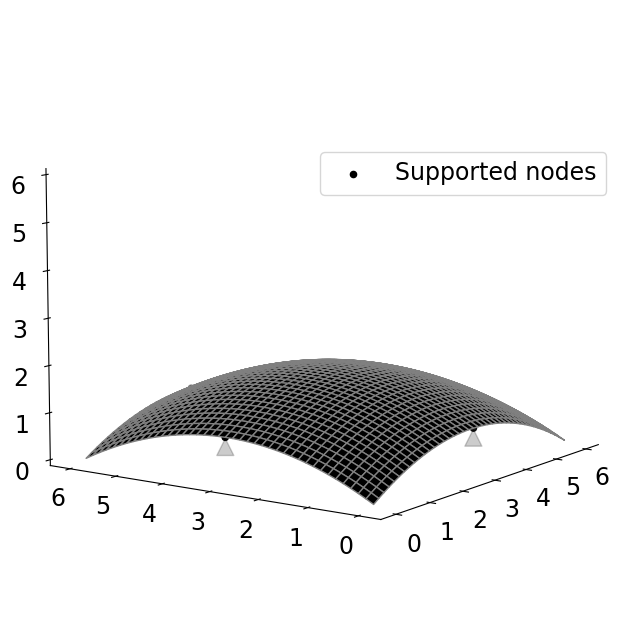

In [4]:
%matplotlib inline




fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,6)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=17)
ax.tick_params(axis='both', which='minor', labelsize=17)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
  #ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='black')

all_corners = []


for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    all_corners.append([[xs[inode],ys[inode],zs[inode]],
                        [xs[jnode],ys[jnode],zs[jnode]],
                        [xs[mnode],ys[mnode],zs[mnode]],
                        [xs[nnode],ys[nnode],zs[nnode]],
                       ])

tdco = Poly3DCollection(all_corners)
tdco.set_alpha(1)
tdco.set_facecolor('black')
tdco.set_edgecolor('grey')
ax.add_collection3d(tdco)

ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes],color='black',label='Supported nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes]-0.2,s=150,marker='^',alpha=0.2,color='black')
ax.view_init(10, -145)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.show()

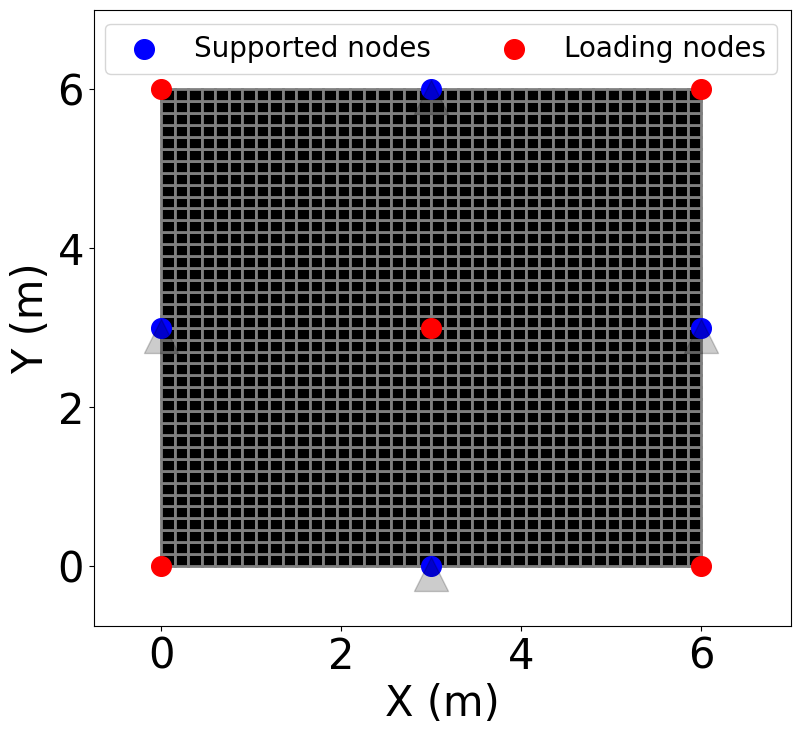

In [5]:
fig,ax = plt.subplots(figsize=(9,8))
ax.set_ylim(-0.75,7)
ax.set_xlim(-0.75,7)
#plt.title('{}-th iteration'.format(i))
plt.xlabel('X (m)',fontsize=30)
plt.ylabel('Y (m)',fontsize=30)
#ax = fig.add_subplot#(projection='3d')
#ax.set_zlim(0,20)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
all_corners= []
import matplotlib as mpl
cmap = mpl.colormaps['binary']
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    this_poly = Polygon([(xs[inode],ys[inode]), (xs[jnode],ys[jnode]), (xs[mnode],ys[mnode]),(xs[nnode],ys[nnode]),])
    alpha = float(1)
    #cthis_poly.set_alpha(alpha)
    this_poly.set_facecolor(cmap(alpha))
    this_poly.set_edgecolor('grey')
    this_poly.set_lw(2)
    ax.add_patch(this_poly)

ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
##  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],color='darkcyan')

ax.scatter(xs[non_design_nodes],ys[non_design_nodes],color='blue',s=200,label='Supported nodes')
ax.scatter(xs[loading_nodes],ys[loading_nodes],color='red',s=200,label='Loading nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes]-0.1,s=600,marker='^',alpha=0.2,color='black')


#cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
#cb.ax.tick_params(labelsize=20)
plt.legend(fontsize=20,ncol=2)# loc=(0.5,0.7))
ax.grid(False)
plt.show()

In [6]:
def Linear_filter(dist,R):
    '''
    A linear filter with radius R, will be normalized later to satisfy unit-intergral condition.
    '''
    return np.where(dist>R,0,(1/R)*(R-dist))

r = 1.5 #Radius

Mapping for nodal distance filter

In [7]:
#Matrix storing XY-projected distance  
dx_ij = xs[:,None]-xs[None,:]
dy_ij = ys[:,None]-ys[None,:]
D_ij = (dx_ij**2 + dy_ij**2)**0.5

#Create the filter mapping matrix
B_ij_ini = Linear_filter(D_ij,r)
B_ij_sum = np.sum(B_ij_ini,axis=1)
B_ij_sum = B_ij_sum.repeat(xs.shape[0]).reshape(xs.shape[0],xs.shape[0])
B_ij = B_ij_ini/B_ij_sum

In [8]:
zs_filtered = zs.copy()
zs_filtered[design_nodes] =(B_ij@zs_filtered)[design_nodes]

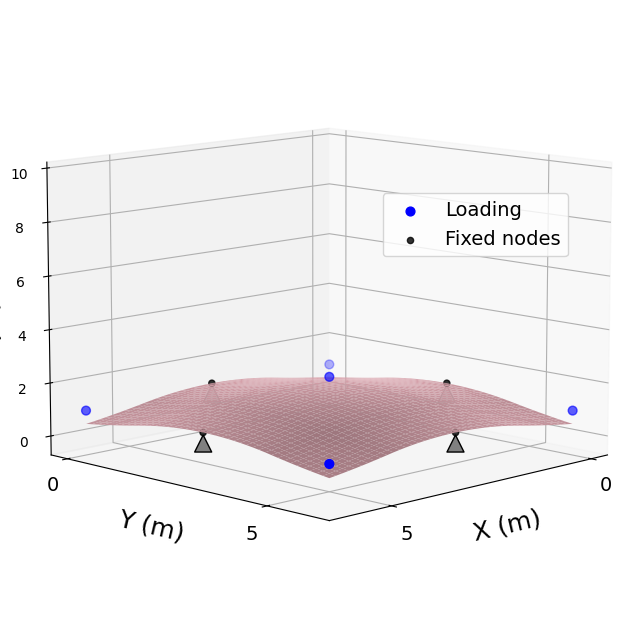

In [9]:
col = n_col+1
row = n_row+1 
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
X = xs.reshape((row,col))
Y = ys.reshape((row,col))
Z = zs_filtered.reshape((row,col))
ax.set_xlabel('X (m)',fontsize=18)
ax.set_ylabel('Y (m)',fontsize=18)
ax.set_zlabel('Z (m)',fontsize=18)
plt.yticks([0,5,10,15,20],fontsize=14)
plt.xticks([0,5,10,15,20],fontsize=14)

ax.set_zlim(-0.5, 20)
ax.set_zlim(-0.5, 20)
ax.set_zlim(-0.5, 10)
ax.plot_surface(X, Y, Z, color='pink')#cmap=plt.cm.YlGnBu_r) 
ax.scatter(xs[loading_nodes],ys[loading_nodes],zs_filtered[loading_nodes]+0.5,color='blue',label='Loading',s=40)
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs_filtered[non_design_nodes],color='black',alpha=0.8,label='Fixed nodes',s=20)
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs_filtered[non_design_nodes]-0.4, s=150, facecolors='grey', edgecolors='black',marker='^')
ax.view_init(10, 45)
plt.legend(loc=(0.6,0.6),fontsize=14)

Mapping for shell-center distance filter

In [10]:
xs_shell = np.average(xs[cnct],axis=1)
ys_shell = np.average(ys[cnct],axis=1)

In [11]:
#Matrix storing XY-projected distance  
dx_ij_shell = xs_shell[:,None]-xs_shell[None,:]
dy_ij_shell = ys_shell[:,None]-ys_shell[None,:]
D_ij_shell = (dx_ij_shell**2 + dy_ij_shell**2)**0.5

#Create the filter mapping matrix
B_ij_ini_shell = Linear_filter(D_ij_shell,0.25)
B_ij_sum_shell = np.sum(B_ij_ini_shell,axis=1)
B_ij_sum_shell = B_ij_sum_shell.repeat(xs_shell.shape[0]).reshape(xs_shell.shape[0],xs_shell.shape[0])
B_ij_shell = B_ij_ini_shell/B_ij_sum_shell

In [12]:
B_ij_shell.shape

(1600, 1600)

In [13]:
#W(A): total volume
def coeff_E(mu,p=7):
    '''
    SIMP: modified stiffness with penalty
    mu is vector representing shell element's density ratio, between 0 and 1.
    E= mu^p * E_0 (p is the penalty factor and it is taken as 5)
    ''' 
    global E
    return mu**p*E

def coeff_E2(mu):
    '''
    SIMP: modified stiffness with penalty
    mu is vector representing shell element's density ratio, between 0 and 1.
    E= mu^p * E_0 (p is the penalty factor and it is taken as 5)
    ''' 
    global E
    return mu**2*E


def og_p(p_norm):
    '''
    Return the un-normalized p
    '''
    p_max = 3
    p_min = 0
    return (p_max-p_min)*p_norm+p_min

def norm_p(p):
    p_max = 3
    p_min = 0
    return  (p-p_min)/(p_max-p_min)


def plt_plan(mu_opt_filtered,i=0):
    fig,ax = plt.subplots(figsize=(11,10))
    ax.set_ylim(-2,8)
    ax.set_xlim(-2,8)
    #plt.title('{}-th iteration'.format(i))
    plt.xlabel('X (m)',fontsize=30)
    plt.ylabel('Y (m)',fontsize=30)
    #ax = fig.add_subplot#(projection='3d')
    #ax.set_zlim(0,20)
    #ax.set_xlabel('X (m)',fontsize=15)
    #ax.set_ylabel('Y (m)',fontsize=15)
    #ax.set_zlabel('Z (m)',fontsize=15)
    all_corners= []
    import matplotlib as mpl
    cmap = mpl.colormaps['binary']
    for i in range(n_ele):
        inode = cnct[i,0]
        jnode = cnct[i,1]
        mnode = cnct[i,2]
        nnode = cnct[i,3]
        this_poly = Polygon([(xs[inode],ys[inode]), (xs[jnode],ys[jnode]), (xs[mnode],ys[mnode]),(xs[nnode],ys[nnode]),])
        alpha = float(mu_opt_filtered[i])
        #cthis_poly.set_alpha(alpha)
        this_poly.set_facecolor(cmap(alpha))
        this_poly.set_edgecolor('black')
        this_poly.set_lw(2)
        ax.add_patch(this_poly)

    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.tick_params(axis='both', which='minor', labelsize=30)
    #Plot a basic wireframe.
    #for i in range(n_ele_bar):
    ##  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],color='darkcyan')

    ax.scatter(xs[non_design_nodes],ys[non_design_nodes],color='black',label='Non-design nodes')
    ax.scatter(xs[non_design_nodes],ys[non_design_nodes],s=150,marker='^',alpha=0.2,color='black')


    cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
    cb.ax.tick_params(labelsize=20)
    plt.legend(fontsize=20)# loc=(0.5,0.7))
    ax.grid(False)
    plt.show()

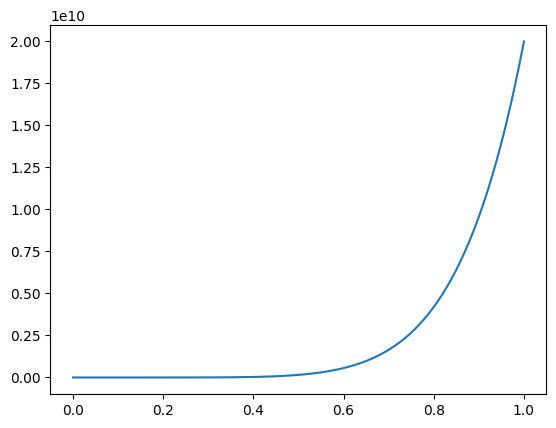

In [14]:
plt.plot(np.linspace(0,1,100),coeff_E(np.linspace(0,1,100)))

In [15]:
#%%
#Create model
model = Model.Model() #model for sensitivity analysis

#Adding nodes and boundary conditions
for i in range(n_node):
    model.add_node(i,xs[i],ys[i],zs_filtered[i])
    if i in non_design_nodes:
        model.add_support(i,[1,1,1,0,0,0]) #Pinned, only Ry allow
    if i in loading_nodes:
        model.add_nodal_load(i,nodal_load=[0.0,0.0,-Q,0.0,0.0,0.0])

#Adding elements
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    model.add_quad(i,inode, jnode, mnode, nnode, 
                t, E, nu)

model.model_ready()




In [16]:
model.solve()

In [17]:
# Start the SSO model
sso_model = SSO_model(model) # initial sso model


#Nodal parameter: for shape optimization
for node in design_nodes:
    nodeparameter = NodeParameter(node,2) # nodeparamter object
    sso_model.add_nodeparameter(nodeparameter)

'''#Element parameter: 
for eletag in range(n_ele):
    eleparameter = ElementParameter(eletag,ele_type = 1,prop_type = 1) # element object, quad's young's modulus
    sso_model.add_eleparameter(eleparameter)'''


#Initial the parameters
sso_model.initialize_parameters_values()
sso_model.set_objective(objective='strain energy',func=None,func_args=None)

# NN

1. Input of NN: 
* XY of nodes

2. Outoput:
* Z
* Density ?


In [18]:
import pymesh
from flax import linen as nn

In [19]:
class SimpleNN(nn.Module):
    num_hidden : int   # Number of hidden neurons
    num_outputs : int  # Number of output neurons
    num_layers: int #Number of hidden layers

    @nn.compact  # Tells Flax to look for defined submodules
    def __call__(self, x):
        # Perform the calculation of the model to determine the prediction
        for i in range(self.num_layers):
            x = nn.Dense(features=self.num_hidden)(x)
            #x = nn.BatchNorm(use_running_average=not train)(x)
            x = nn.relu(x)
        x = nn.Dense(features=self.num_outputs)(x)
        x = nn.sigmoid(x) #Between 0 and 1
        return x

In [20]:
n_input = 2 #(X,Y) of each node
n_hidden = 40 # neurons
n_out = 1 #Z of each node & density
n_layers =3 #number of hidden layers

rng = jax.random.PRNGKey(42)

inp = np.abs(np.array([(xs-x_span/2)/np.max(xs),(ys-y_span/2)/np.max(ys)]).T)#,v_cen
#rng, inp_rng, init_rng = jax.random.split(rng, 3)

In [21]:
NN = SimpleNN(n_hidden,n_out,n_layers)

In [22]:
rng, init_rng = jax.random.split(rng, 2)
rng, init_rng = jax.random.split(rng, 2)
# Initialize the model
params = NN.init(init_rng, inp)

In [23]:
import optax
optimizer = optax.adam(learning_rate=0.02)

In [24]:
from flax.training import train_state

model_state = train_state.TrainState.create(apply_fn=NN.apply,
                                            params=params,
                                            tx=optimizer)

In [27]:
def calculate_loss(state, params, inp):


    ##Apply_fn: ML input to output
    outs = state.apply_fn(params, inp) #shape (n_node,2)
    node_params = outs[:,0]
    node_rho_params = outs[:,1]
    
    #1. NN outputs to update shape (nodal-Z coordinate)
    p = jnp.array(zs).copy()
    p = p.at[design_nodes].set(og_p(node_params)) #Unnormalized Control pt
    z = (B_ij@p)[design_nodes] #filtered actual geometry pt
    
    #sso_model.update_nodeparameter(z) # Update the model, this step causes "leak".... try directly call sso's function.
    

    
    #3. Loss function: penalized compliance
    parameter_values = z#jnp.hstack([z,E_step])
    compliance = sso_model.helper_params_to_objective(parameter_values,which_solver='sparse',enforce_scipy_sparse=True)
    # loss = compliance (normalized) + alpha *(volume/exp_volume -1)^2
    loss1 = compliance
    #loss2 = alpha*(jnp.sum(filtered_mu)/(0.5*sso_model.eleparameters_values.shape[0])-1)**2
    #loss =  loss1 + loss2
    return loss1#loss1,loss2,z,filtered_mu

In [28]:
calculate_loss(model_state,params,inp)

Array(167.22821414, dtype=float64)

In [29]:
grad_fn = jax.value_and_grad(calculate_loss,  # Function to calculate the loss
                                 argnums=1,  # Parameters are second argument of the function
                                 has_aux=False  # Function has additional outputs, here accuracy
                                )
    # Determine gradients for current model, parameters and batch
loss, grads = grad_fn(model_state, model_state.params, inp)

In [71]:
@jax.jit  # Jit the function for efficiency
def train_step(state, inp):
    # Gradient function
    grad_fn = jax.value_and_grad(calculate_loss,  # Function to calculate the loss
                                 argnums=1,  # Parameters are second argument of the function
                                 has_aux=False  # Function has additional outputs, here accuracy
                                )
    # Determine gradients for current model, parameters and batch
    loss, grads = grad_fn(state, state.params, inp, p)
    # Perform parameter update with gradients and optimizer
    state = state.apply_gradients(grads=grads)
    # Return state and any other value we might want
    return state, loss

In [29]:
%timeit train_step(model_state, inp)

2.67 s ± 11.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [72]:
metrics_history = {'train_loss': []}
from tqdm import tqdm
loss_list =[]
def train_model(state, num_epochs=200):
    alpha = 0.1
    p = 2
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        if alpha < 100:
            alpha = 0.1 +len(loss_list) * 0.05
        if p<8:
            p = 2 + 0.06*len(loss_list)
        state, loss = train_step(state, inp,alpha,p)
        metrics_history['train_loss'].append(loss)
        print('Train epoch {}'.format(len(metrics_history['train_loss'])+1)+'  ,loss:{}'.format(loss))
        # We could use the loss and accuracy for logging here, e.g. in TensorBoard
        # For simplicity, we skip this part here
        loss_list.append(loss)
        if len(loss_list)%5==0:
            i = len(loss_list)
            
            outs = state.apply_fn(state.params, inp) #shape (n_node,2)
            node_params = outs[:,0]
            node_rho_params = outs[:,1]



            #sso_model.update_nodeparameter(z) # Update the model, this step causes "leak".... try directly call sso's function.

            #2. NN outputs to update topology (density, NN output is per-node density, average for each shell)
            ele_params = jnp.average(node_rho_params[cnct],axis=1) #Average per-node density for each shell
            filtered_mu = B_ij_shell@ele_params
            E_step = coeff_E(filtered_mu) #Penalized Young's modulus
            print(jnp.sum(ele_params))
            
            plt_plan(filtered_mu,i)
    return state

  1%|          | 1/105 [00:40<1:09:45, 40.25s/it]

Train epoch 2  ,loss:9.587567803427275


  2%|▏         | 2/105 [00:42<31:12, 18.18s/it]  

Train epoch 3  ,loss:2.966859486974684


  3%|▎         | 3/105 [00:45<18:57, 11.15s/it]

Train epoch 4  ,loss:2.120844128978043


  4%|▍         | 4/105 [00:48<13:11,  7.84s/it]

Train epoch 5  ,loss:1.507042225609893
Train epoch 6  ,loss:1.2447210417948227
1174.7796395471607


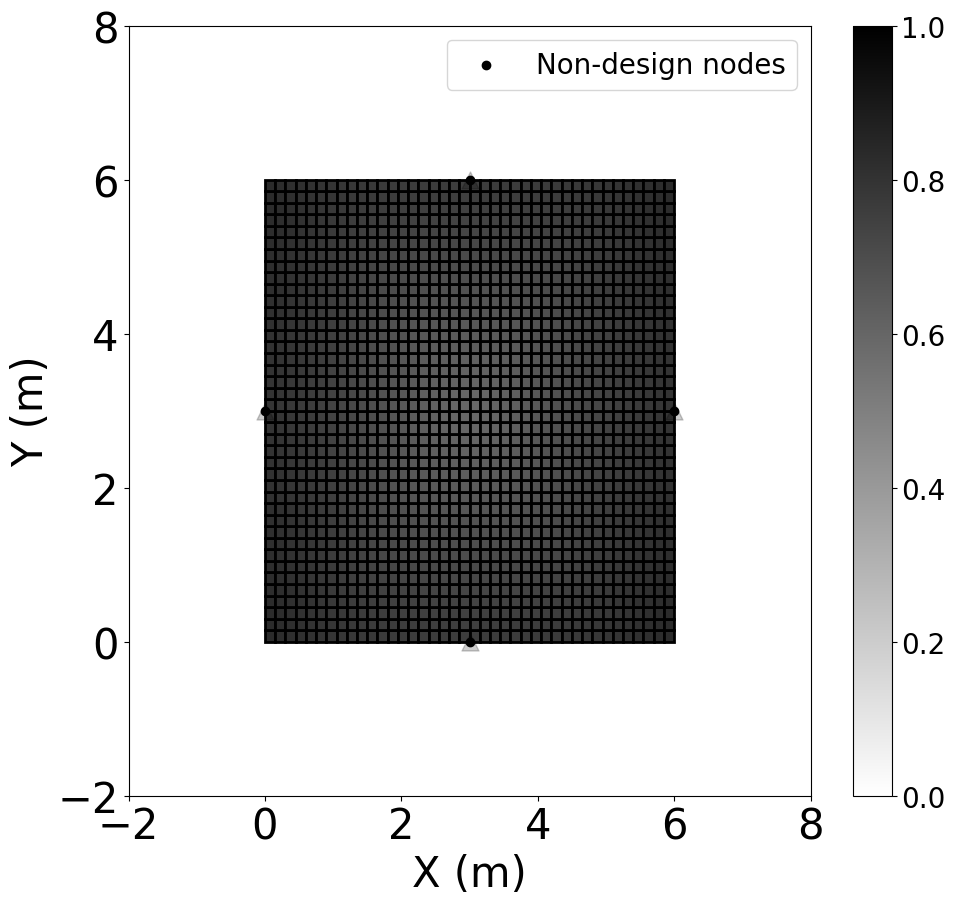

  6%|▌         | 6/105 [00:55<08:38,  5.24s/it]

Train epoch 7  ,loss:1.176445127207258


  7%|▋         | 7/105 [00:58<07:13,  4.43s/it]

Train epoch 8  ,loss:1.2050365843941715


  8%|▊         | 8/105 [01:00<06:18,  3.90s/it]

Train epoch 9  ,loss:1.2452369814201136


  9%|▊         | 9/105 [01:03<05:39,  3.54s/it]

Train epoch 10  ,loss:1.265729492238387
Train epoch 11  ,loss:1.2510869470158705
1261.9962526545878


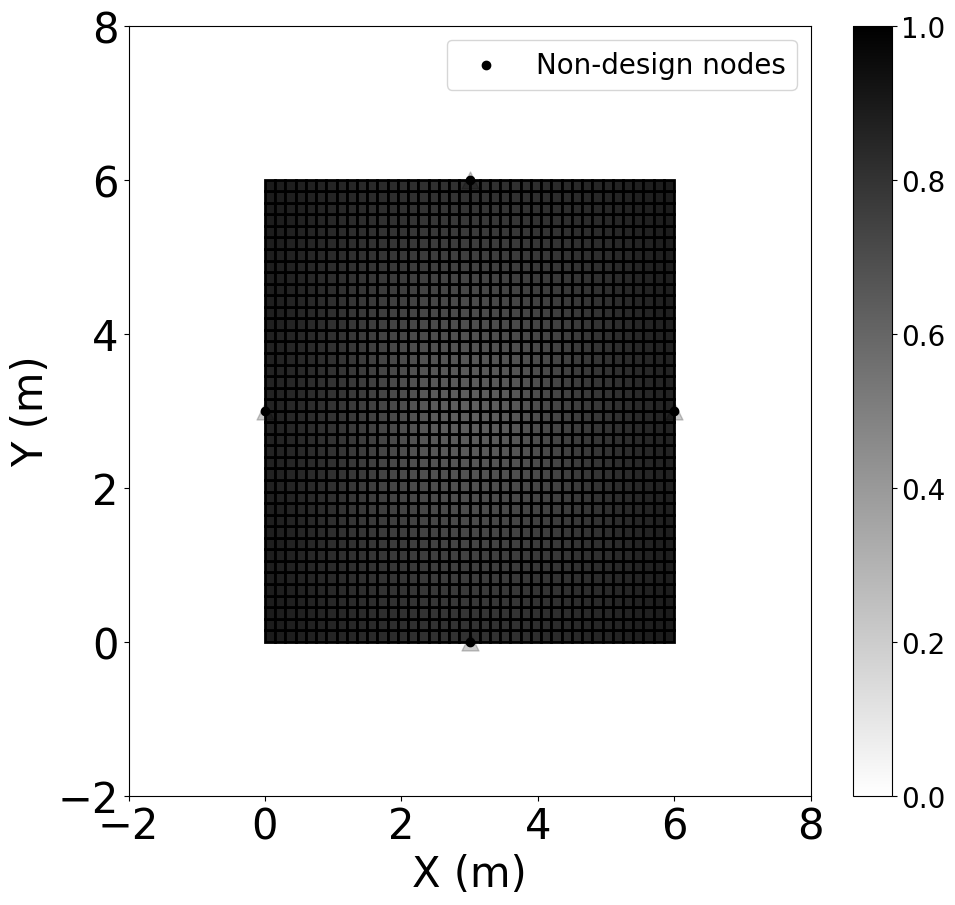

 10%|█         | 11/105 [01:11<05:32,  3.54s/it]

Train epoch 12  ,loss:1.1975768302091374


 11%|█▏        | 12/105 [01:13<05:07,  3.31s/it]

Train epoch 13  ,loss:1.1074180116834327


 12%|█▏        | 13/105 [01:16<04:49,  3.15s/it]

Train epoch 14  ,loss:0.9872304601801524


 13%|█▎        | 14/105 [01:19<04:36,  3.04s/it]

Train epoch 15  ,loss:0.8495085752907006
Train epoch 16  ,loss:0.715045282162206
1003.2681253832907


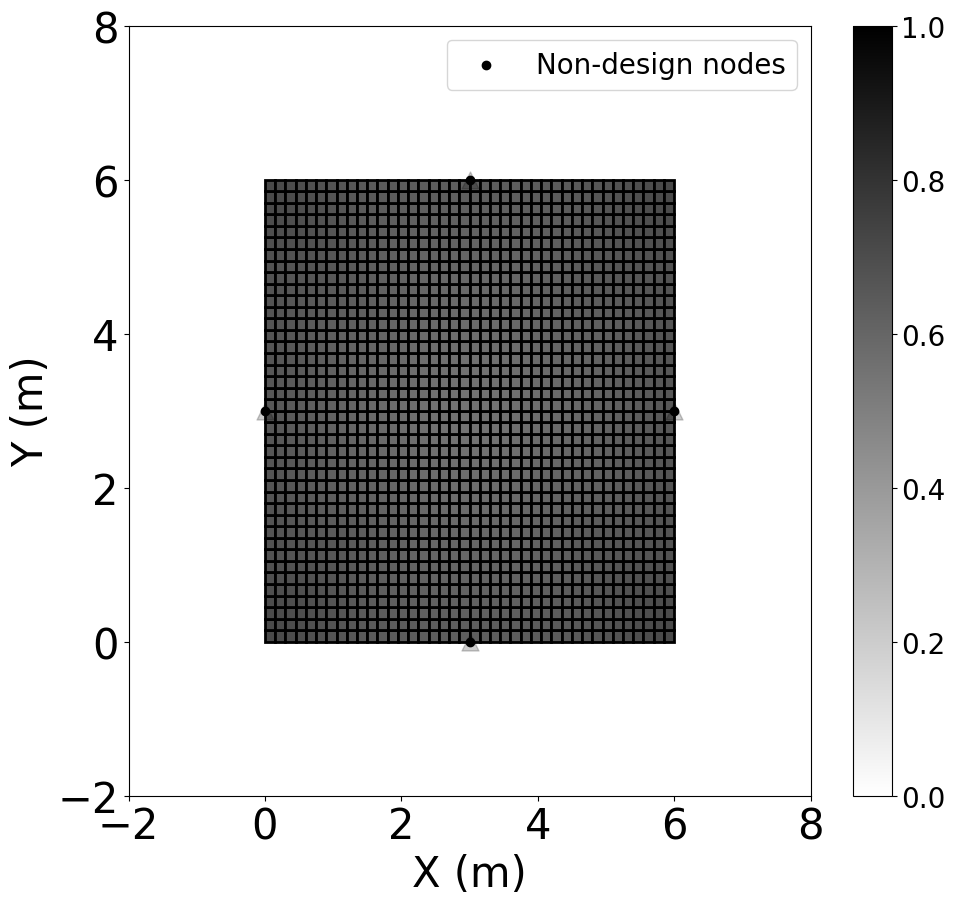

 15%|█▌        | 16/105 [01:26<04:44,  3.20s/it]

Train epoch 17  ,loss:0.6003830860559899


 16%|█▌        | 17/105 [01:29<04:30,  3.07s/it]

Train epoch 18  ,loss:0.5419201158175261


 17%|█▋        | 18/105 [01:31<04:20,  2.99s/it]

Train epoch 19  ,loss:0.557887154426062


 18%|█▊        | 19/105 [01:34<04:11,  2.92s/it]

Train epoch 20  ,loss:0.5982570266317645
Train epoch 21  ,loss:0.5895128854738075
784.9823611622289


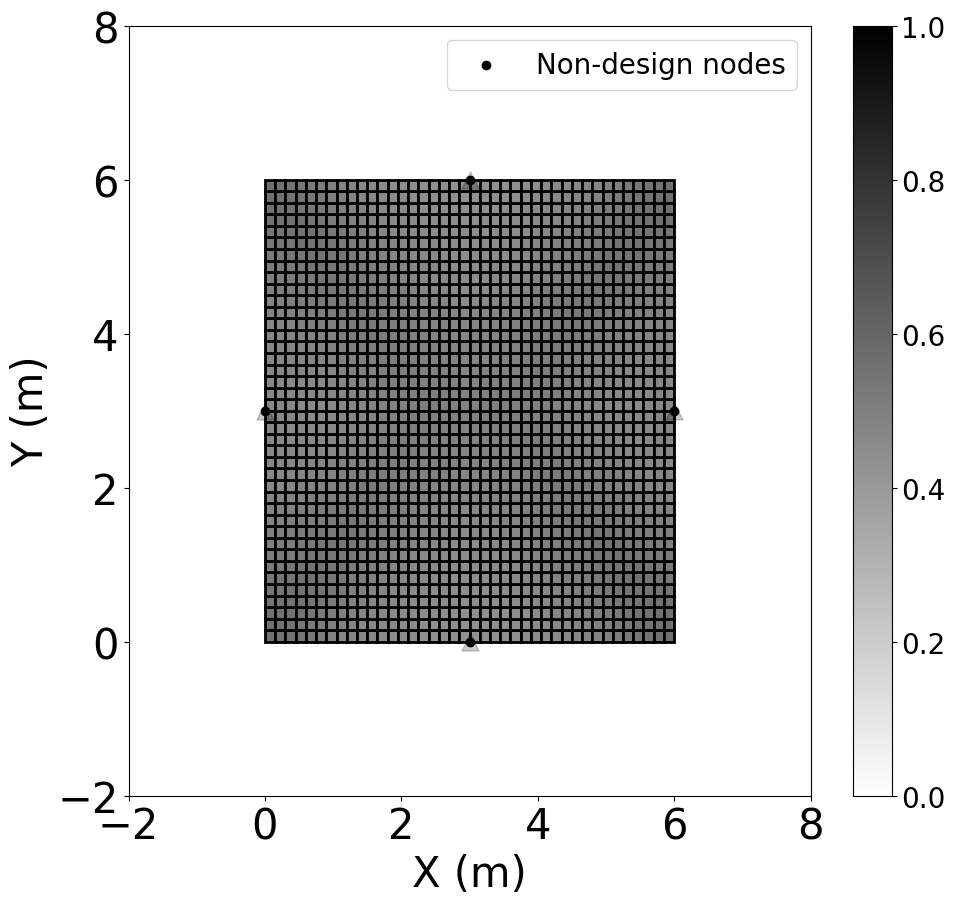

 20%|██        | 21/105 [01:42<04:30,  3.22s/it]

Train epoch 22  ,loss:0.5380892036992458


 21%|██        | 22/105 [01:44<04:16,  3.09s/it]

Train epoch 23  ,loss:0.48177597248129317


 22%|██▏       | 23/105 [01:47<04:05,  2.99s/it]

Train epoch 24  ,loss:0.43617888955832146


 23%|██▎       | 24/105 [01:50<03:57,  2.93s/it]

Train epoch 25  ,loss:0.39669694411418815
Train epoch 26  ,loss:0.3670523775932947
889.5795267122078


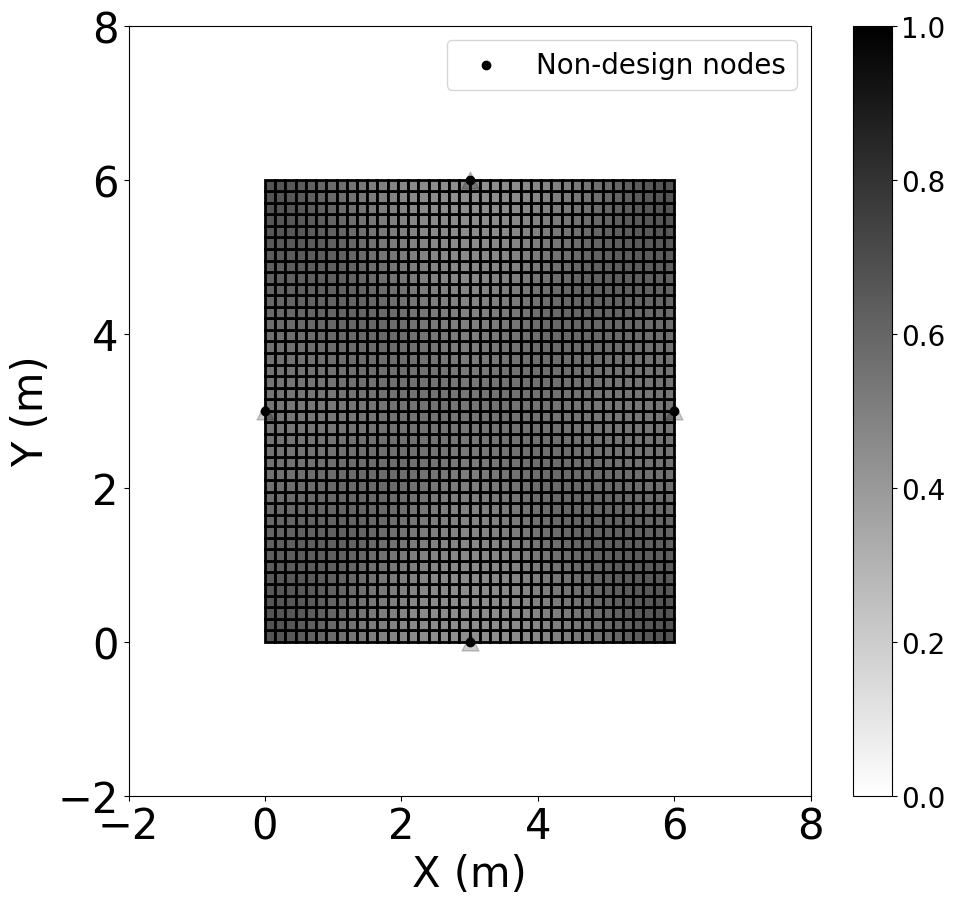

 25%|██▍       | 26/105 [01:57<04:08,  3.15s/it]

Train epoch 27  ,loss:0.34454598010630344


 26%|██▌       | 27/105 [02:00<03:57,  3.04s/it]

Train epoch 28  ,loss:0.32563385444480936


 27%|██▋       | 28/105 [02:02<03:48,  2.96s/it]

Train epoch 29  ,loss:0.30774478600515204


 28%|██▊       | 29/105 [02:05<03:41,  2.91s/it]

Train epoch 30  ,loss:0.28878985339320895
Train epoch 31  ,loss:0.26954677224053397
860.9915029687731


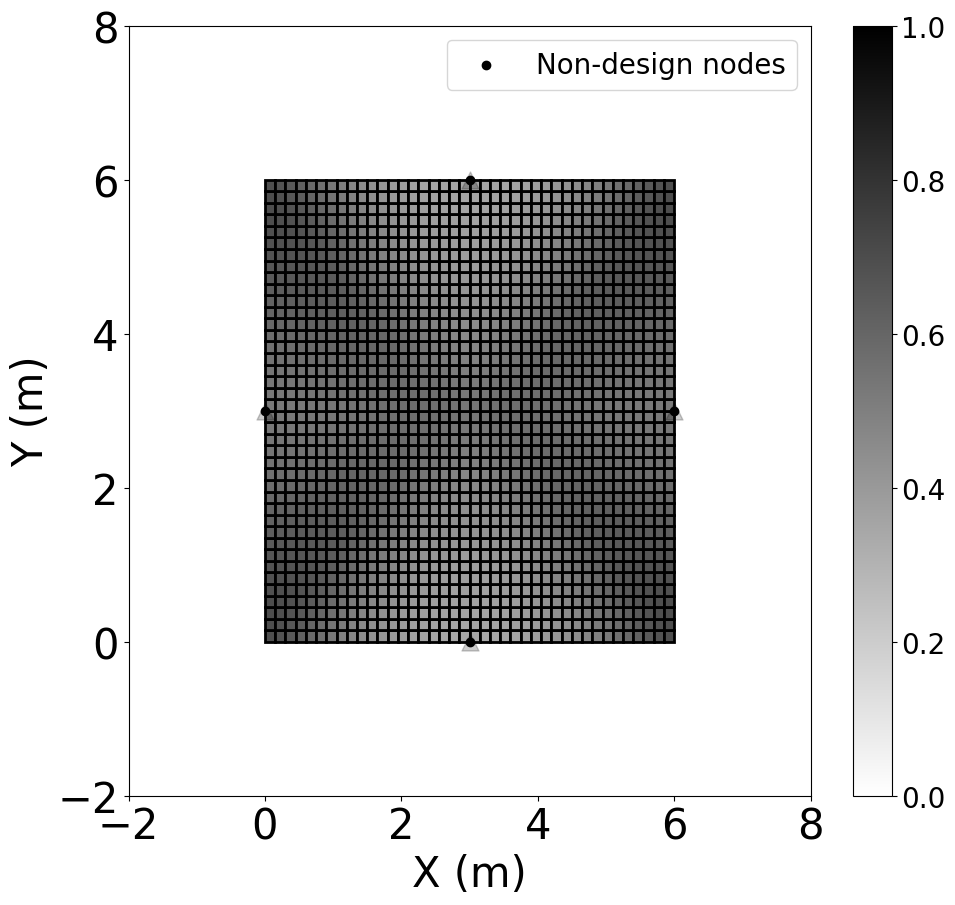

 30%|██▉       | 31/105 [02:13<03:58,  3.22s/it]

Train epoch 32  ,loss:0.2530220063799823


 30%|███       | 32/105 [02:15<03:45,  3.09s/it]

Train epoch 33  ,loss:0.24138346970352428


 31%|███▏      | 33/105 [02:18<03:35,  3.00s/it]

Train epoch 34  ,loss:0.2326003948577798


 32%|███▏      | 34/105 [02:21<03:28,  2.93s/it]

Train epoch 35  ,loss:0.2197033484757816
Train epoch 36  ,loss:0.20337133527787749
823.1215940497871


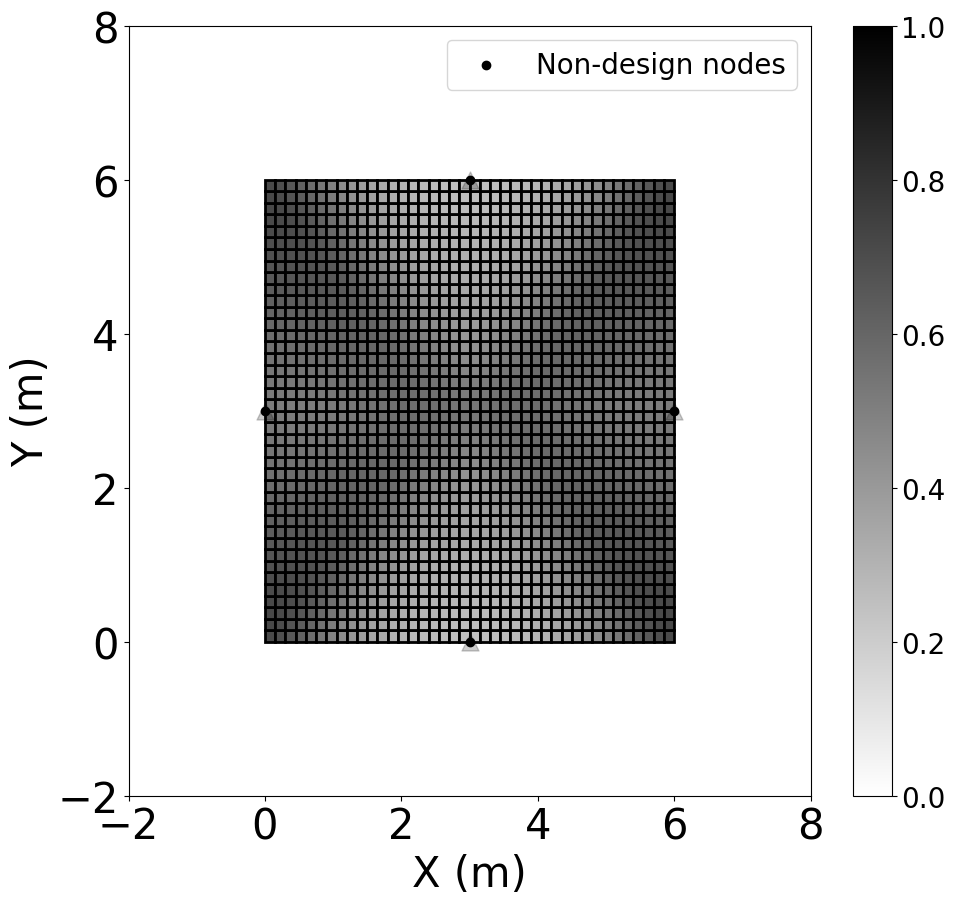

 34%|███▍      | 36/105 [02:28<03:38,  3.16s/it]

Train epoch 37  ,loss:0.18917572529953297


 35%|███▌      | 37/105 [02:31<03:27,  3.06s/it]

Train epoch 38  ,loss:0.17699931673369682


 36%|███▌      | 38/105 [02:34<03:19,  2.98s/it]

Train epoch 39  ,loss:0.16708140101493735


 37%|███▋      | 39/105 [02:36<03:13,  2.93s/it]

Train epoch 40  ,loss:0.1579292625639311
Train epoch 41  ,loss:0.14931789705917026
816.9334197329019


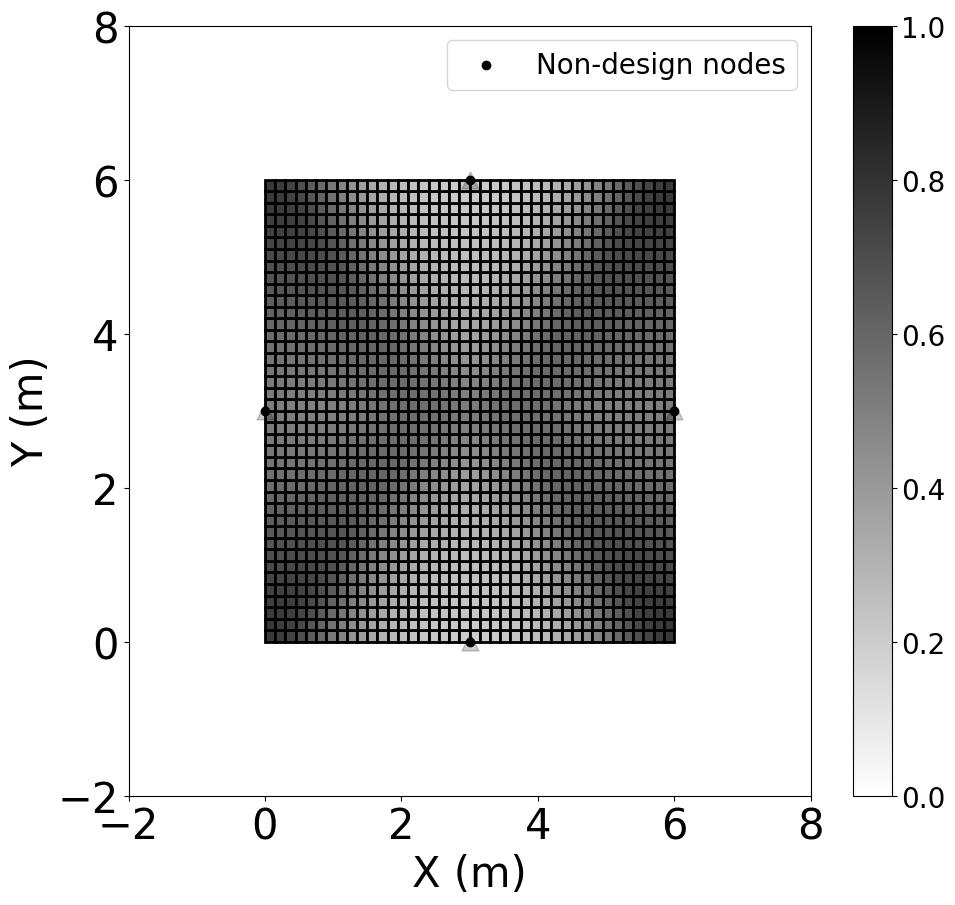

 39%|███▉      | 41/105 [02:43<03:21,  3.15s/it]

Train epoch 42  ,loss:0.14124131862061615


 40%|████      | 42/105 [02:46<03:11,  3.04s/it]

Train epoch 43  ,loss:0.13505036136586826


 41%|████      | 43/105 [02:49<03:03,  2.96s/it]

Train epoch 44  ,loss:0.1307123613915279


 42%|████▏     | 44/105 [02:52<02:57,  2.91s/it]

Train epoch 45  ,loss:0.1264615542592538
Train epoch 46  ,loss:0.12184832629913604
806.3636863658168


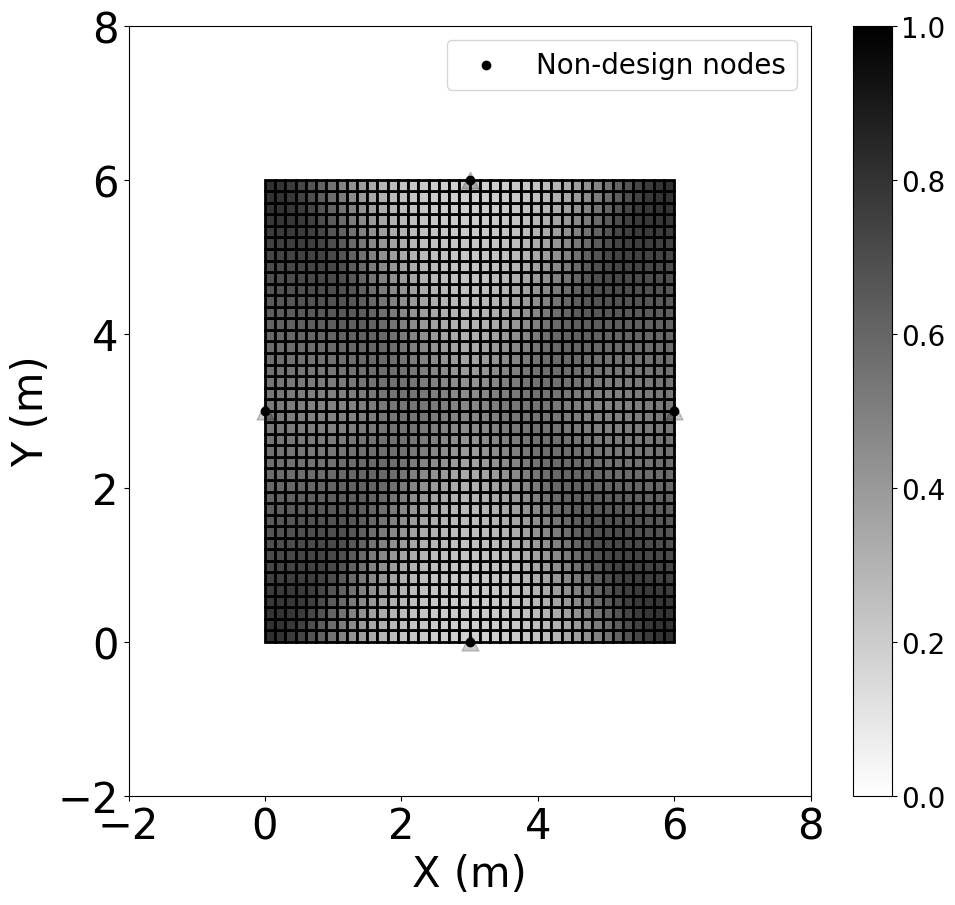

 44%|████▍     | 46/105 [02:59<03:11,  3.25s/it]

Train epoch 47  ,loss:0.11740876470731933


 45%|████▍     | 47/105 [03:02<03:00,  3.11s/it]

Train epoch 48  ,loss:0.11383964016399584


 46%|████▌     | 48/105 [03:05<02:51,  3.01s/it]

Train epoch 49  ,loss:0.11094597547709478


 47%|████▋     | 49/105 [03:08<02:44,  2.95s/it]

Train epoch 50  ,loss:0.10839674361967132
Train epoch 51  ,loss:0.10563325516657897
802.9601429759862


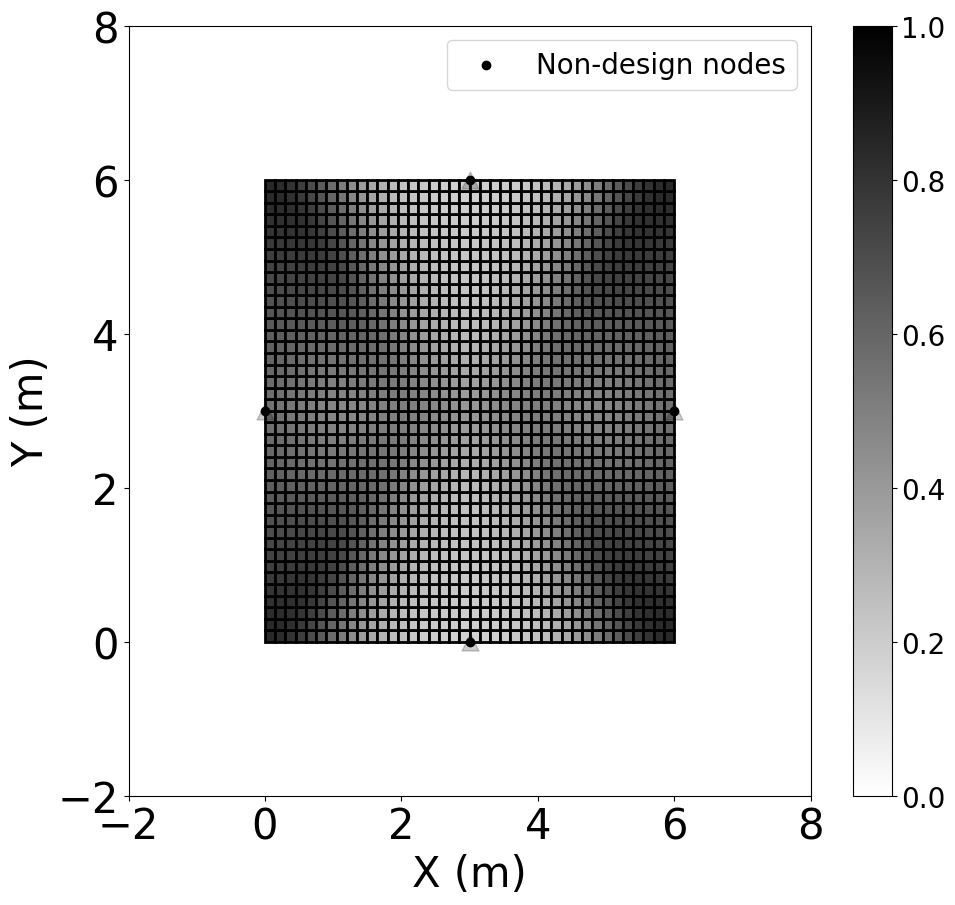

 49%|████▊     | 51/105 [03:14<02:50,  3.16s/it]

Train epoch 52  ,loss:0.10292280304342019


 50%|████▉     | 52/105 [03:17<02:41,  3.04s/it]

Train epoch 53  ,loss:0.10057461916443731


 50%|█████     | 53/105 [03:20<02:34,  2.97s/it]

Train epoch 54  ,loss:0.0980474219954261


 51%|█████▏    | 54/105 [03:23<02:28,  2.92s/it]

Train epoch 55  ,loss:0.09541115367776898
Train epoch 56  ,loss:0.09296193523660336
804.3270697571481


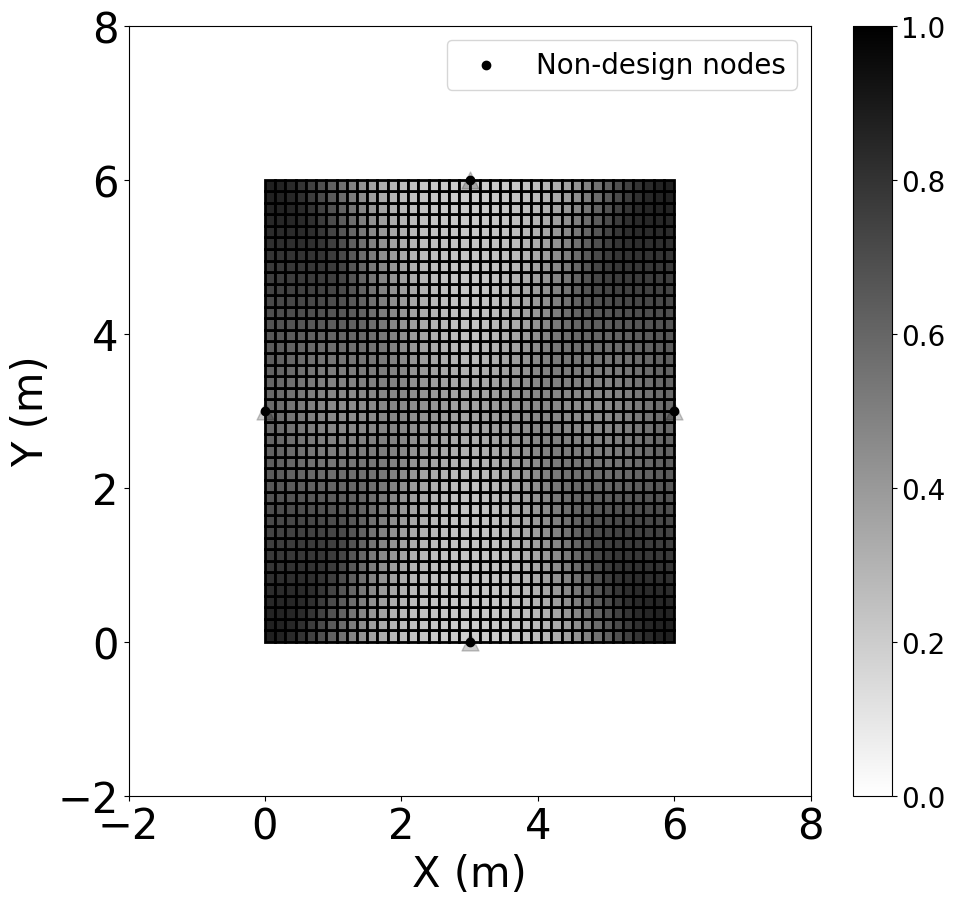

 53%|█████▎    | 56/105 [03:30<02:38,  3.23s/it]

Train epoch 57  ,loss:0.090718267814804


 54%|█████▍    | 57/105 [03:33<02:28,  3.09s/it]

Train epoch 58  ,loss:0.08868270329265061


 55%|█████▌    | 58/105 [03:36<02:21,  3.00s/it]

Train epoch 59  ,loss:0.0865278587720925


 56%|█████▌    | 59/105 [03:39<02:15,  2.94s/it]

Train epoch 60  ,loss:0.08456842270758257
Train epoch 61  ,loss:0.08290687832495734
802.318153195012


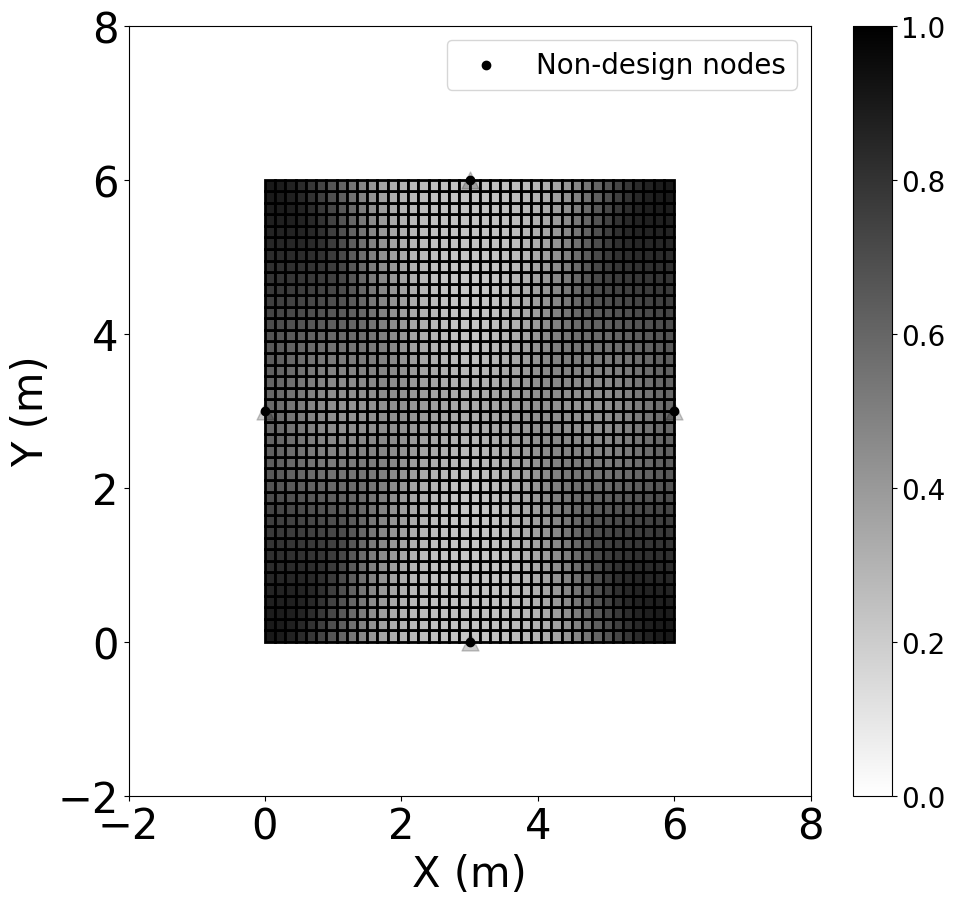

 58%|█████▊    | 61/105 [03:46<02:18,  3.15s/it]

Train epoch 62  ,loss:0.08140216352079385


 59%|█████▉    | 62/105 [03:48<02:10,  3.04s/it]

Train epoch 63  ,loss:0.08014239738302785


 60%|██████    | 63/105 [03:51<02:04,  2.97s/it]

Train epoch 64  ,loss:0.07915315056339713


 61%|██████    | 64/105 [03:54<01:59,  2.91s/it]

Train epoch 65  ,loss:0.0786408374438555
Train epoch 66  ,loss:0.07880585257351767
793.0381548366763


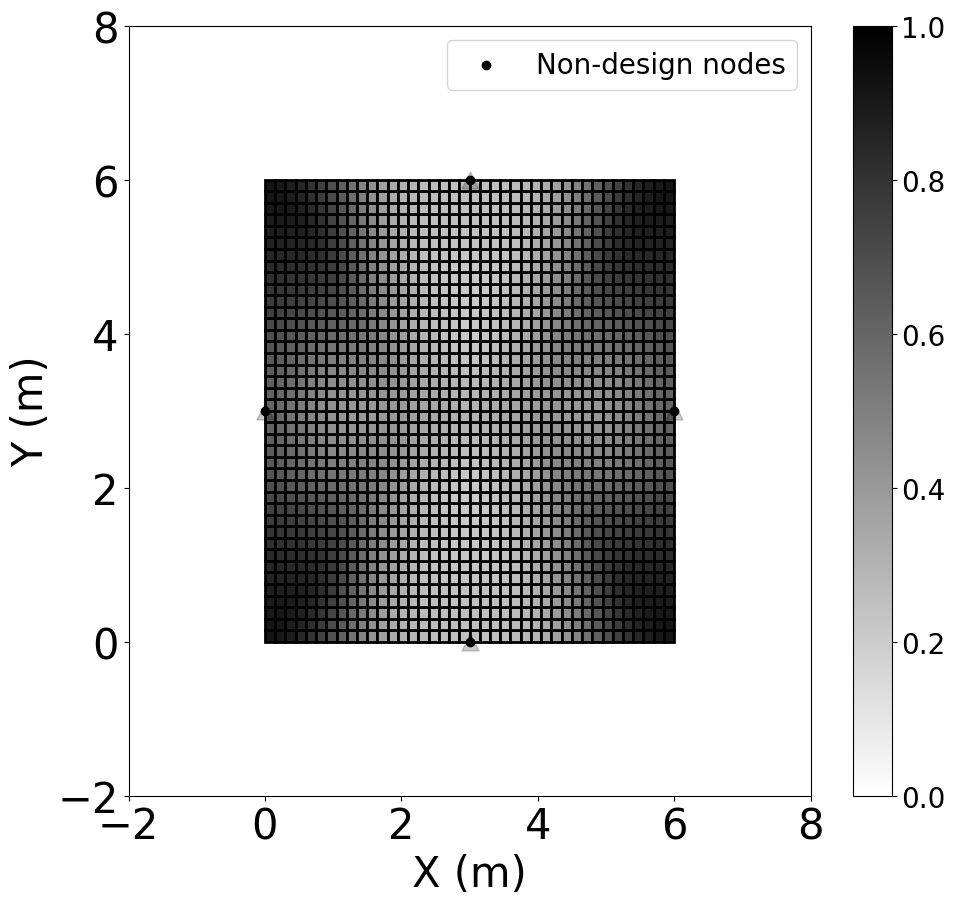

 63%|██████▎   | 66/105 [04:01<02:02,  3.14s/it]

Train epoch 67  ,loss:0.07790235679275977


 64%|██████▍   | 67/105 [04:04<01:55,  3.04s/it]

Train epoch 68  ,loss:0.07583464793050876


 65%|██████▍   | 68/105 [04:06<01:49,  2.96s/it]

Train epoch 69  ,loss:0.07565399639973852


 66%|██████▌   | 69/105 [04:09<01:44,  2.91s/it]

Train epoch 70  ,loss:0.07552922222362293
Train epoch 71  ,loss:0.0739285503624757
809.6410106414737


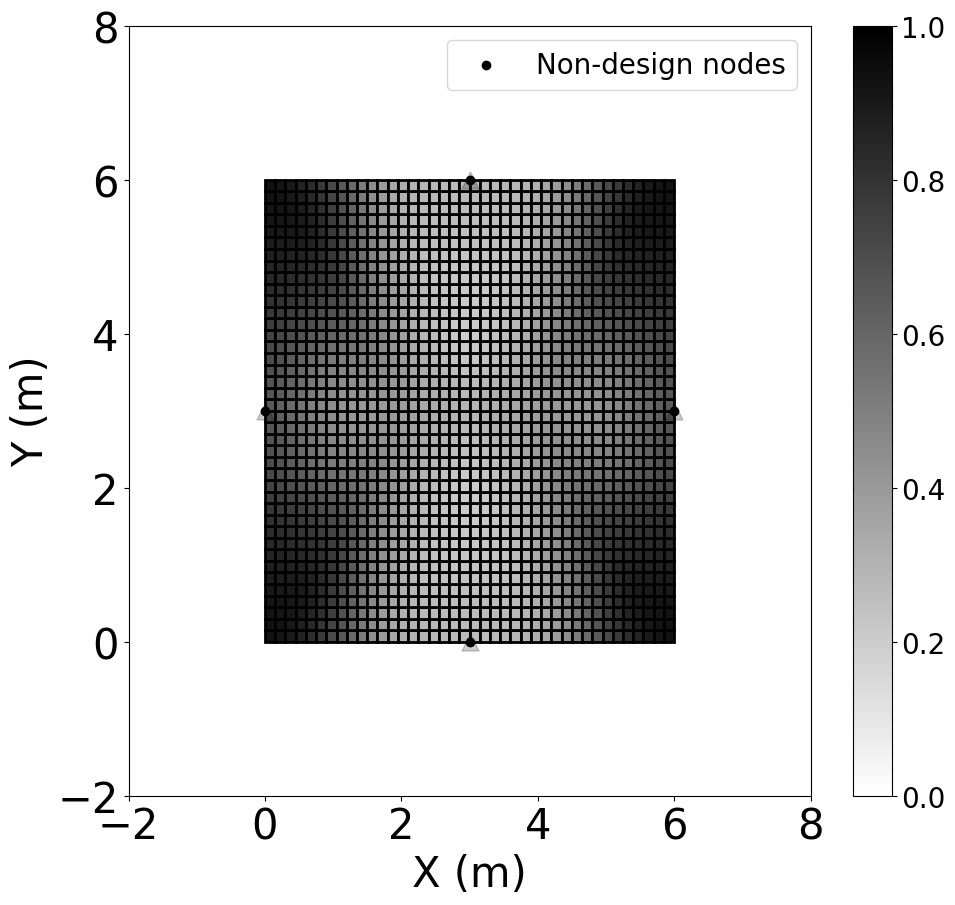

 68%|██████▊   | 71/105 [04:17<01:50,  3.24s/it]

Train epoch 72  ,loss:0.07368225556472877


 69%|██████▊   | 72/105 [04:19<01:42,  3.10s/it]

Train epoch 73  ,loss:0.07362840274741073


 70%|██████▉   | 73/105 [04:22<01:36,  3.01s/it]

Train epoch 74  ,loss:0.07246398969702499


 70%|███████   | 74/105 [04:25<01:31,  2.94s/it]

Train epoch 75  ,loss:0.07217601731191693
Train epoch 76  ,loss:0.07200112167383814
807.1465148200931


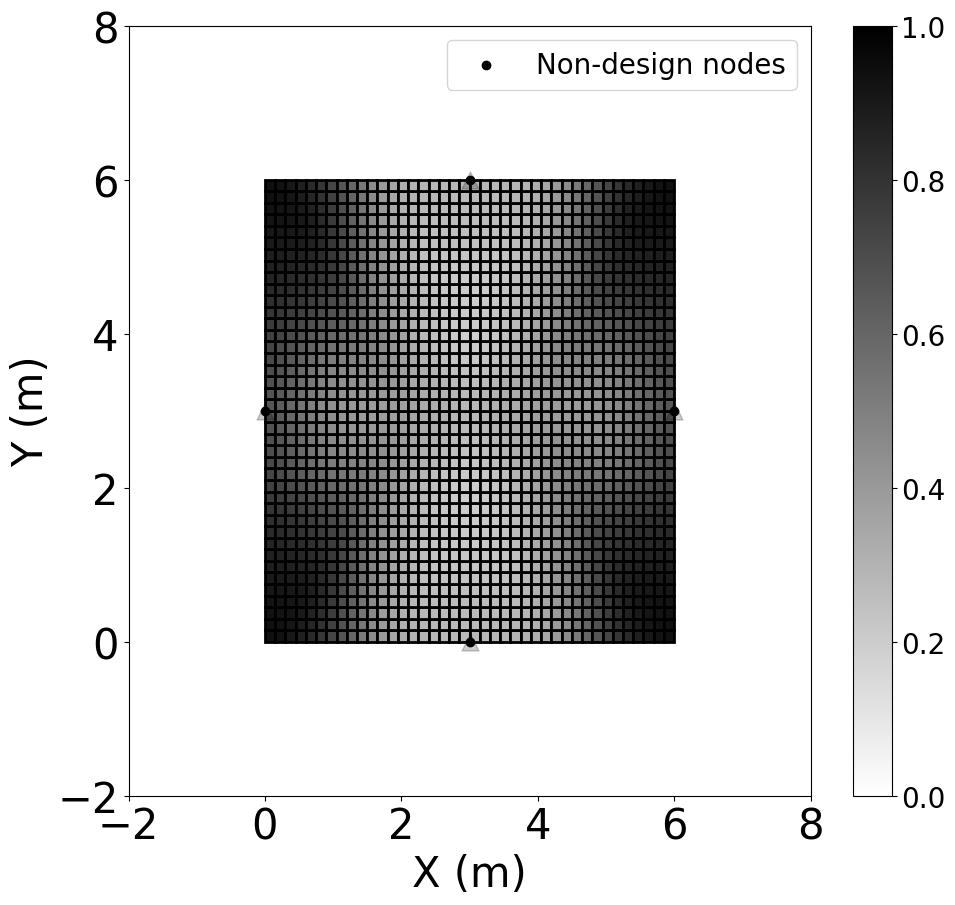

 72%|███████▏  | 76/105 [04:32<01:31,  3.17s/it]

Train epoch 77  ,loss:0.07104315013593444


 73%|███████▎  | 77/105 [04:35<01:25,  3.05s/it]

Train epoch 78  ,loss:0.07062736268723294


 74%|███████▍  | 78/105 [04:38<01:20,  2.97s/it]

Train epoch 79  ,loss:0.07061767923426301


 75%|███████▌  | 79/105 [04:40<01:15,  2.92s/it]

Train epoch 80  ,loss:0.07003915117628888
Train epoch 81  ,loss:0.06919471921386944
798.792278958424


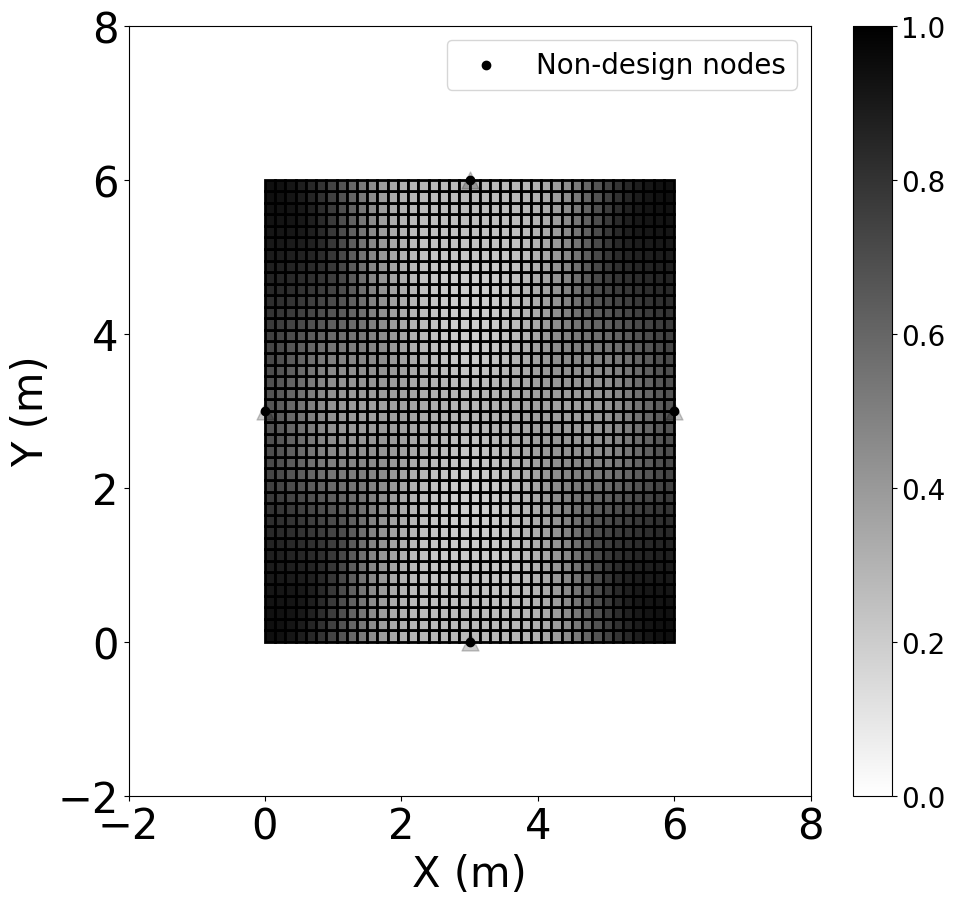

 77%|███████▋  | 81/105 [04:48<01:17,  3.23s/it]

Train epoch 82  ,loss:0.06899963222180883


 78%|███████▊  | 82/105 [04:51<01:11,  3.10s/it]

Train epoch 83  ,loss:0.06889436185464422


 79%|███████▉  | 83/105 [04:53<01:06,  3.00s/it]

Train epoch 84  ,loss:0.0682538045191607


 80%|████████  | 84/105 [04:56<01:01,  2.94s/it]

Train epoch 85  ,loss:0.06765533004063155
Train epoch 86  ,loss:0.06741174021397095
797.5628005496526


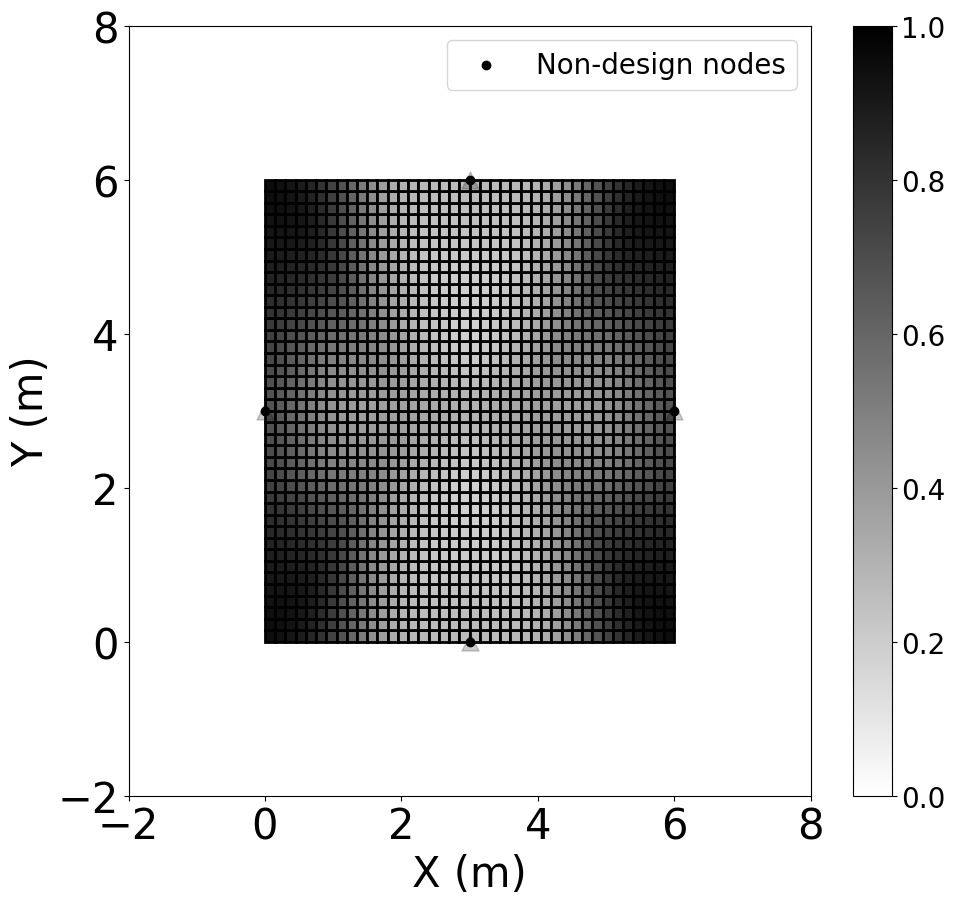

 82%|████████▏ | 86/105 [05:03<00:59,  3.16s/it]

Train epoch 87  ,loss:0.06725742288427194


 83%|████████▎ | 87/105 [05:06<00:54,  3.04s/it]

Train epoch 88  ,loss:0.06693961472310757


 84%|████████▍ | 88/105 [05:09<00:50,  2.96s/it]

Train epoch 89  ,loss:0.06638725848214305


 85%|████████▍ | 89/105 [05:11<00:46,  2.91s/it]

Train epoch 90  ,loss:0.06591592853455965
Train epoch 91  ,loss:0.0656598509863839
798.1634187934033


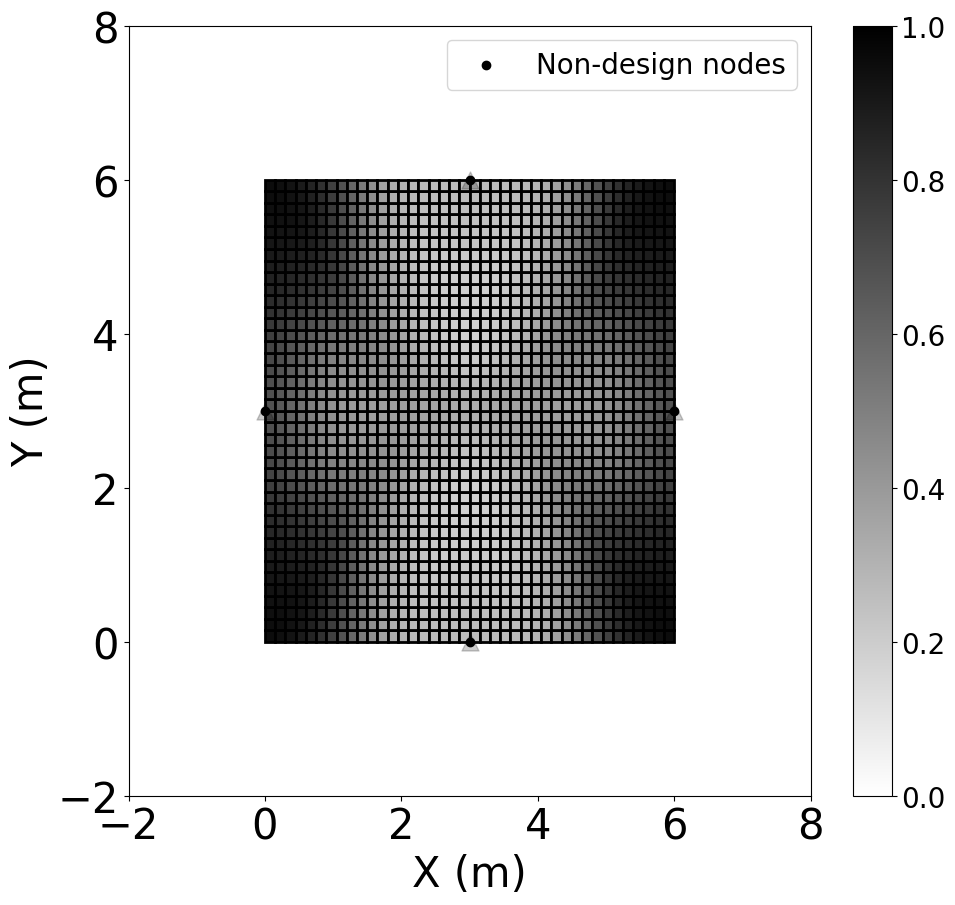

 87%|████████▋ | 91/105 [05:18<00:43,  3.13s/it]

Train epoch 92  ,loss:0.06554434294177953


 88%|████████▊ | 92/105 [05:21<00:39,  3.03s/it]

Train epoch 93  ,loss:0.0654222822953721


 89%|████████▊ | 93/105 [05:24<00:35,  2.96s/it]

Train epoch 94  ,loss:0.06517110945751875


 90%|████████▉ | 94/105 [05:27<00:31,  2.91s/it]

Train epoch 95  ,loss:0.0648075098606659
Train epoch 96  ,loss:0.06433903223014716
805.4503549140612


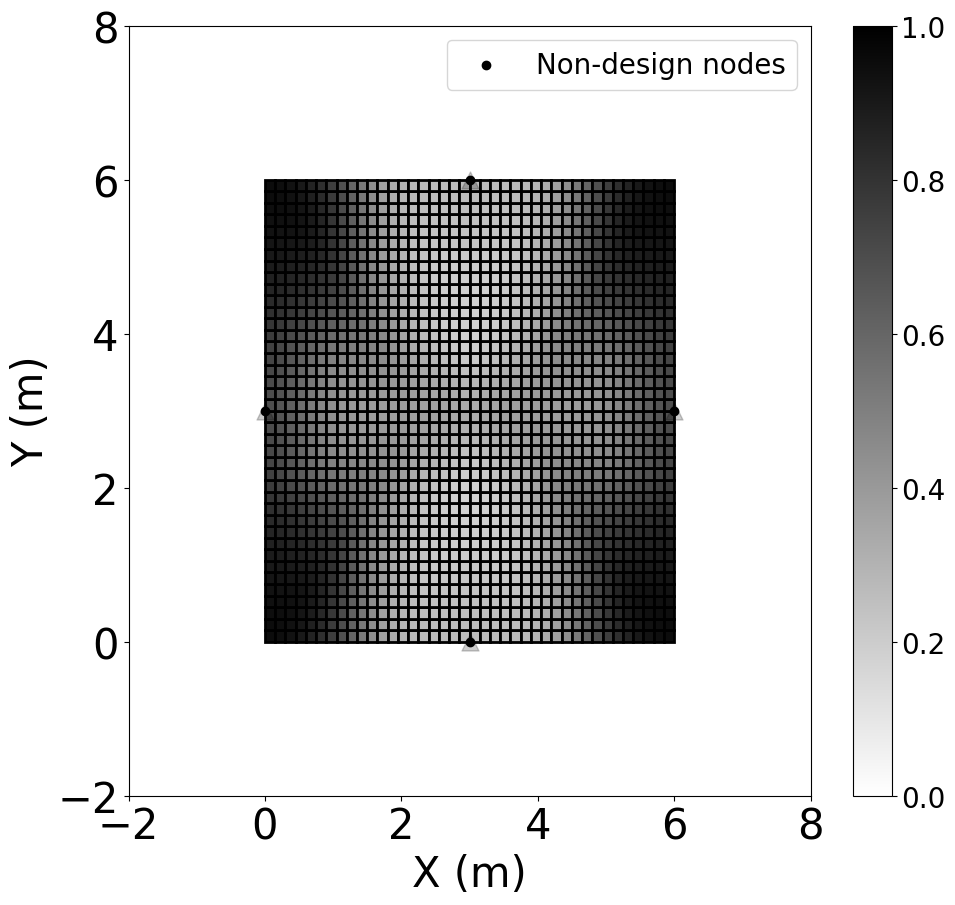

 91%|█████████▏| 96/105 [05:34<00:29,  3.24s/it]

Train epoch 97  ,loss:0.06390192235681383


 92%|█████████▏| 97/105 [05:37<00:24,  3.11s/it]

Train epoch 98  ,loss:0.06353759451331173


 93%|█████████▎| 98/105 [05:40<00:21,  3.01s/it]

Train epoch 99  ,loss:0.0632556640021399


 94%|█████████▍| 99/105 [05:43<00:17,  2.94s/it]

Train epoch 100  ,loss:0.06302960951187418
Train epoch 101  ,loss:0.06285164112858113
807.1317781548213


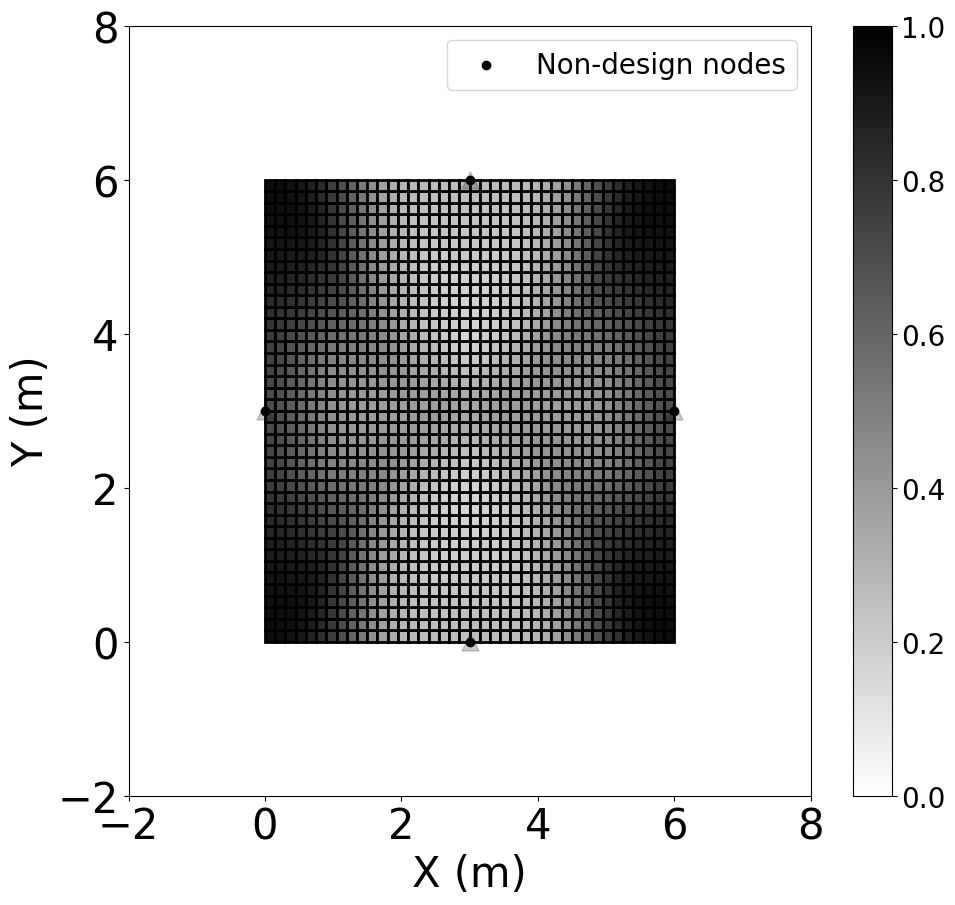

 96%|█████████▌| 101/105 [05:50<00:12,  3.15s/it]

Train epoch 102  ,loss:0.06279693822360478


 97%|█████████▋| 102/105 [05:52<00:09,  3.04s/it]

Train epoch 103  ,loss:0.06300217995543915


 98%|█████████▊| 103/105 [05:55<00:05,  2.96s/it]

Train epoch 104  ,loss:0.06384311667059797


 99%|█████████▉| 104/105 [05:58<00:02,  2.91s/it]

Train epoch 105  ,loss:0.06489697648639012
Train epoch 106  ,loss:0.06550270426532433
790.3644758488501


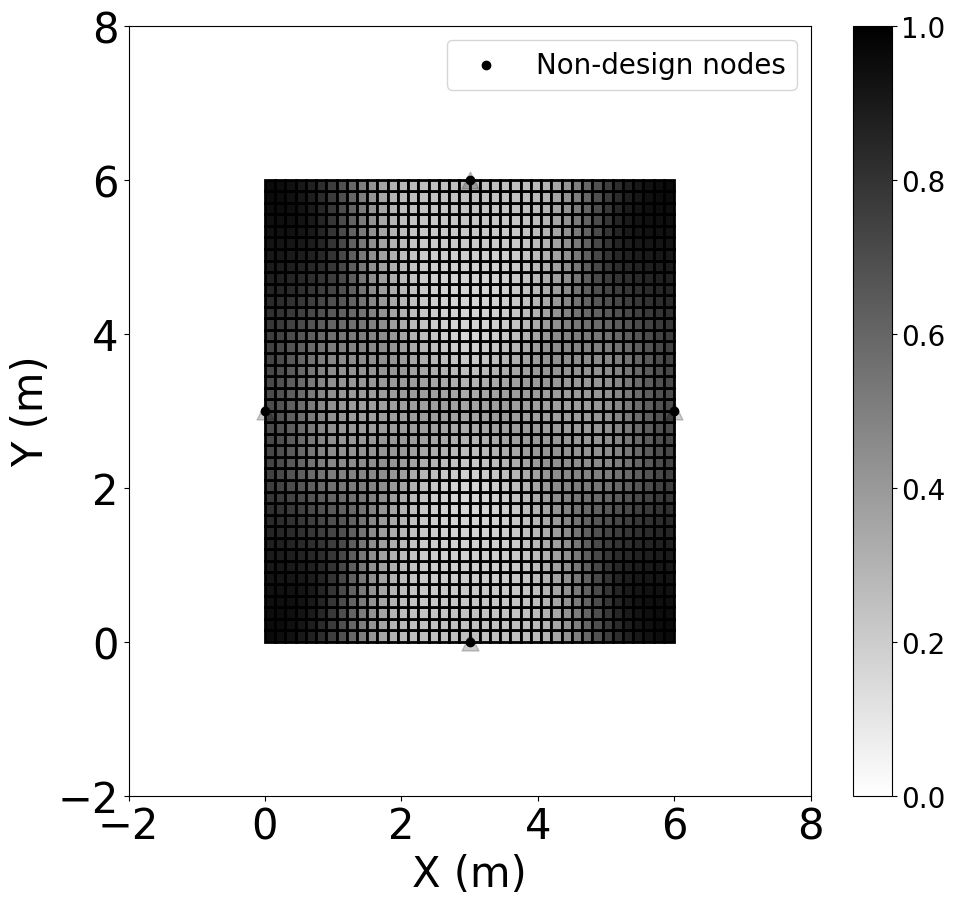

100%|██████████| 105/105 [06:02<00:00,  3.46s/it]


In [73]:
trained_model_state = train_model(model_state, num_epochs=105)

In [32]:
##Apply_fn: ML input to output
outs = trained_model_state.apply_fn(trained_model_state.params, inp) #how to move nodes along z, ML-Outpu
node_params = outs[:,0]
node_rho_params = outs[:,1]

#Final-Z
zs[design_nodes] = og_p(node_params)
zs_filtered = zs.copy()
zs_filtered[design_nodes] =(B_ij@zs)[design_nodes]

#Final density
mu_opt = jnp.average(node_rho_params[cnct],axis=1) #Average per-node density for each shell

In [42]:
outs[:,0]

Array([0.15064163, 0.30012599, 0.54851817, ..., 0.54851817, 0.30012599,
       0.15064163], dtype=float64)

In [130]:
design_nodes[20]

20

In [123]:
zs[non_design_nodes]

array([0.53679601, 2.9963183 , 1.62004906, 1.69808352])

# Visualization

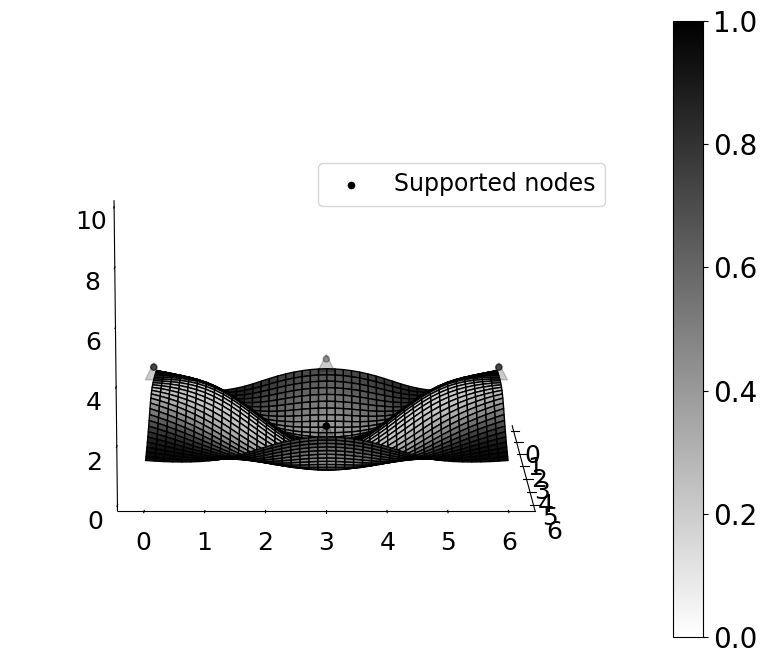

In [75]:
%matplotlib inline




fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,10)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
  #ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='black')


import matplotlib as mpl
cmap = mpl.colormaps['binary']
mu_opt_filtered = B_ij_shell@mu_opt
for i in range(n_ele):
    all_corners = []
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    all_corners.append([[xs[inode],ys[inode],zs_filtered[inode]],
                        [xs[jnode],ys[jnode],zs_filtered[jnode]],
                        [xs[mnode],ys[mnode],zs_filtered[mnode]],
                        [xs[nnode],ys[nnode],zs_filtered[nnode]],
                       ])
    #all_corners.append([[xs[inode],ys[inode],zs[inode]],
    #                    [xs[jnode],ys[jnode],zs[jnode]],
    #                    [xs[mnode],ys[mnode],zs[mnode]],
    #                    [xs[nnode],ys[nnode],zs[nnode]],
    #                   ])
    
    tdco = Poly3DCollection(all_corners)
    alpha = float(mu_opt_filtered[i])
    tdco.set_facecolor(cmap(alpha))
    tdco.set_edgecolor('black')
    ax.add_collection3d(tdco)
    


cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
cb.ax.tick_params(labelsize=20)
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs_filtered[non_design_nodes]+0.35,color='black',label='Supported nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs_filtered[non_design_nodes]+0.2,s=150,marker='^',alpha=0.2,color='black')
ax.view_init(10, 0)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.show()

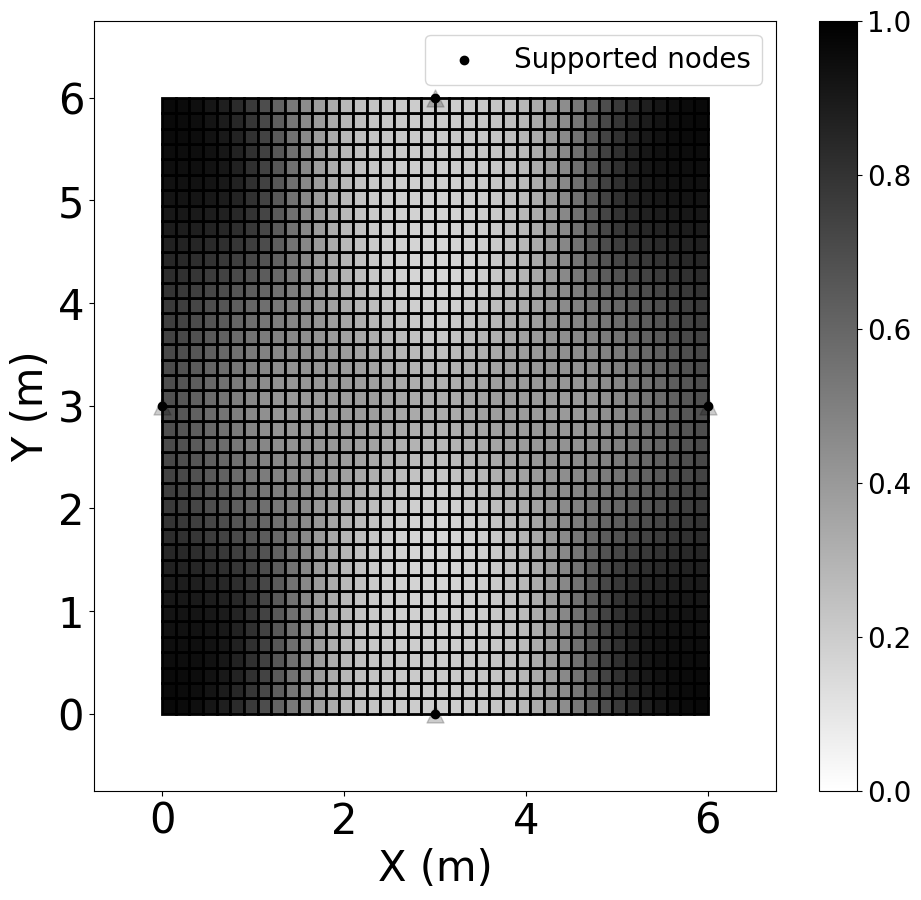

In [34]:

fig,ax = plt.subplots(figsize=(11,10))
ax.set_ylim(-0.75,6.75)
ax.set_xlim(-0.75,6.75)
plt.xlabel('X (m)',fontsize=30)
plt.ylabel('Y (m)',fontsize=30)
#ax = fig.add_subplot#(projection='3d')
#ax.set_zlim(0,20)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
all_corners= []
import matplotlib as mpl
cmap = mpl.colormaps['binary']
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    this_poly = Polygon([(xs[inode],ys[inode]), (xs[jnode],ys[jnode]), (xs[mnode],ys[mnode]),(xs[nnode],ys[nnode]),])
    alpha = float(mu_opt_filtered[i])
    #cthis_poly.set_alpha(alpha)
    this_poly.set_facecolor(cmap(alpha))
    this_poly.set_edgecolor('black')
    this_poly.set_lw(2)
    ax.add_patch(this_poly)

ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
##  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],color='darkcyan')

ax.scatter(xs[non_design_nodes],ys[non_design_nodes],color='black',label='Supported nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],s=150,marker='^',alpha=0.2,color='black')


cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
cb.ax.tick_params(labelsize=20)
plt.legend(fontsize=20)# loc=(0.5,0.7))
ax.grid(False)
plt.show()

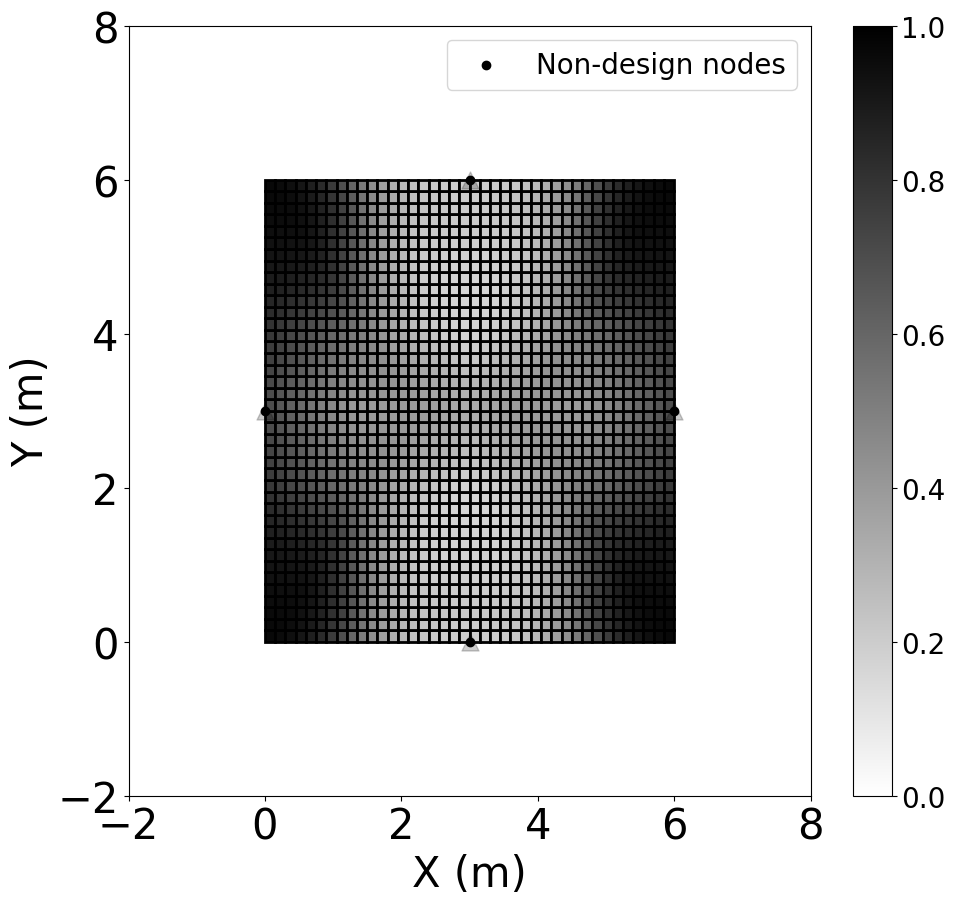

In [35]:

fig,ax = plt.subplots(figsize=(11,10))
ax.set_ylim(-2,8)
ax.set_xlim(-2,8)
plt.xlabel('X (m)',fontsize=30)
plt.ylabel('Y (m)',fontsize=30)
#ax = fig.add_subplot#(projection='3d')
#ax.set_zlim(0,20)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
all_corners= []
import matplotlib as mpl
cmap = mpl.colormaps['binary']
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    this_poly = Polygon([(xs[inode],ys[inode]), (xs[jnode],ys[jnode]), (xs[mnode],ys[mnode]),(xs[nnode],ys[nnode]),])
    alpha = float(mu_opt[i])
    #cthis_poly.set_alpha(alpha)
    this_poly.set_facecolor(cmap(alpha))
    this_poly.set_edgecolor('black')
    this_poly.set_lw(2)
    ax.add_patch(this_poly)

ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
##  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],color='darkcyan')

ax.scatter(xs[non_design_nodes],ys[non_design_nodes],color='black',label='Non-design nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],s=150,marker='^',alpha=0.2,color='black')


cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
cb.ax.tick_params(labelsize=20)
plt.legend(fontsize=20)# loc=(0.5,0.7))
ax.grid(False)
plt.show()

In [106]:
jnp.sum(mu_opt)

Array(800.34499146, dtype=float64)

In [107]:
jnp.sum(mu_opt)

Array(800.34499146, dtype=float64)

In [108]:
0.5*sso_model.eleparameters_values.shape[0]

800.0

In [ ]:
mu_opt_filtered

In [82]:
jnp.min(mu_opt)

Array(0.49547004, dtype=float64)

In [83]:
jnp.max(mu_opt)

Array(0.54537502, dtype=float64)

In [86]:
jnp.max(model_state.apply_fn(params, inp)[:,1])

Array(0.52117628, dtype=float64)

In [87]:
jnp.min(model_state.apply_fn(params, inp)[:,1])

Array(0.5, dtype=float64)

In [89]:
np.max(zs)

1.827663999013847

In [90]:
np.min(zs)

1.4122399536942798